In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm

# ML libraries
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Time series libraries
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("Set2")

print(f"Python version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

# Define paths
BASE_NSE_DATA_PATH = "C:\\xampp\\htdocs\\PesaGuru\\notebooks\\data\\external\\nse_historical_data"
MACRO_DATA_PATH = "C:\\xampp\\htdocs\\PesaGuru\\notebooks\\data\\external\\macroeconomic_data"
OUTPUT_PATH = "C:\\xampp\\htdocs\\PesaGuru\\notebooks\\data\\processed"

Python version: 2.2.3
NumPy version: 1.26.4
TensorFlow version: 2.10.0
scikit-learn version: 1.6.1


In [2]:
class NSEDataLoader:
    """Class to load and preprocess NSE stock data"""
    
    def __init__(self, data_dir):
        """Initialize with directory containing NSE data files"""
        self.data_dir = data_dir
        self.stock_data = {}
        self.sector_data = {}
        self.combined_data = None
        
    def load_stock_data(self, pattern="NSE_data_all_stocks_*.csv"):
        """Load stock data from multiple CSV files"""
        try:
            # Find all files matching the pattern
            file_paths = glob.glob(os.path.join(self.data_dir, pattern))
            
            if not file_paths:
                print(f"No files found matching pattern: {pattern}")
                return False
            
            # Sort files by name
            file_paths.sort()
            
            # Load each file
            for file_path in file_paths:
                year = self._extract_year_from_path(file_path)
                if year:
                    print(f"Loading data for year {year}...")
                    df = pd.read_csv(file_path)
                    
                    # Standardize column names
                    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
                    
                    # Standardize date column name
                    if 'date' in df.columns:
                        date_col = 'date'
                    else:
                        for col in df.columns:
                            if 'date' in col.lower():
                                date_col = col
                                break
                    
                    # Convert price and numeric columns to float
                    numeric_cols = ['day_price', 'previous', 'change', 'day_low', 'day_high', 
                                   '12m_low', '12m_high', 'volume']
                    for col in numeric_cols:
                        if col in df.columns:
                            df[col] = pd.to_numeric(df[col], errors='coerce')
                    
                    # Convert date to datetime
                    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
                    
                    # Store dataframe with standardized column name
                    if date_col != 'date':
                        df = df.rename(columns={date_col: 'date'})
                    
                    # Add year column
                    df['year'] = year
                    
                    # Store the dataframe
                    self.stock_data[year] = df
            
            print(f"Loaded stock data for {len(self.stock_data)} years.")
            return True
            
        except Exception as e:
            print(f"Error loading stock data: {e}")
            return False
    
    def load_sector_data(self, pattern="NSE_data_stock_market_sectors_*.csv"):
        """Load sector classification data"""
        try:
            # Find all files matching the pattern
            file_paths = glob.glob(os.path.join(self.data_dir, pattern))
            
            if not file_paths:
                print(f"No files found matching pattern: {pattern}")
                return False
            
            # Sort files by name
            file_paths.sort()
            
            # Load each file
            for file_path in file_paths:
                year = self._extract_year_from_path(file_path)
                if year:
                    print(f"Loading sector data for year {year}...")
                    df = pd.read_csv(file_path)
                    
                    # Standardize column names
                    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
                    
                    # Standardize sector and code column names
                    if 'sector' not in df.columns:
                        for col in df.columns:
                            if 'sector' in col.lower():
                                df = df.rename(columns={col: 'sector'})
                                break
                    
                    if 'code' not in df.columns:
                        for col in df.columns:
                            if 'code' in col.lower() or 'stock_code' in col.lower():
                                df = df.rename(columns={col: 'code'})
                                break
                    
                    # Store the dataframe
                    self.sector_data[year] = df
            
            print(f"Loaded sector data for {len(self.sector_data)} years.")
            return True
            
        except Exception as e:
            print(f"Error loading sector data: {e}")
            return False
    
    def _extract_year_from_path(self, file_path):
        """Extract year from file path"""
        import re
        match = re.search(r'(\d{4})', os.path.basename(file_path))
        if match:
            return match.group(1)
        return None
    
    def combine_yearly_data(self):
        """Combine data from all years into a single dataframe"""
        try:
            if not self.stock_data:
                print("No stock data loaded. Please load data first.")
                return None
            
            # Combine all yearly data
            dfs = []
            for year, df in self.stock_data.items():
                # Create a copy to avoid modifying the original
                df_copy = df.copy()
                dfs.append(df_copy)
            
            combined_df = pd.concat(dfs, ignore_index=True)
            
            # Ensure date column is datetime and sorted
            combined_df['date'] = pd.to_datetime(combined_df['date'])
            combined_df = combined_df.sort_values(['code', 'date'])
            
            # Store the combined data
            self.combined_data = combined_df
            
            print(f"Combined data contains {len(combined_df)} rows.")
            return combined_df
            
        except Exception as e:
            print(f"Error combining yearly data: {e}")
            return None
    
    def get_stock_data(self, stock_code, start_date=None, end_date=None):
        """Get historical data for a specific stock with date filtering"""
        if self.combined_data is None:
            self.combine_yearly_data()
        
        if self.combined_data is None:
            return None
        
        # Filter for the specified stock
        stock_data = self.combined_data[self.combined_data['code'] == stock_code].copy()
        
        if stock_data.empty:
            print(f"No data found for stock code: {stock_code}")
            return None
        
        # Apply date filters if provided
        if start_date:
            start_date = pd.to_datetime(start_date)
            stock_data = stock_data[stock_data['date'] >= start_date]
        
        if end_date:
            end_date = pd.to_datetime(end_date)
            stock_data = stock_data[stock_data['date'] <= end_date]
        
        # Sort by date
        stock_data = stock_data.sort_values('date')
        
        return stock_data
    
    def enrich_with_sector_data(self, stock_data, year=None):
        """Add sector information to stock data"""
        if not self.sector_data:
            print("No sector data loaded. Please load sector data first.")
            return stock_data
        
        # If year not specified, find the most appropriate sector data
        if year is None:
            years = list(self.sector_data.keys())
            if not years:
                return stock_data
            # Use the latest year's sector data that doesn't exceed the stock data's year
            stock_years = stock_data['year'].unique()
            valid_sector_years = [y for y in years if y in stock_years]
            if valid_sector_years:
                year = max(valid_sector_years)
            else:
                year = min(years, key=lambda y: abs(int(y) - int(min(stock_years))))
        
        if year not in self.sector_data:
            print(f"No sector data available for year {year}")
            return stock_data
        
        # Get sector data
        sector_df = self.sector_data[year]
        
        # Merge stock data with sector data
        merged_df = pd.merge(
            stock_data,
            sector_df[['code', 'sector']],
            on='code',
            how='left'
        )
        
        return merged_df
    
    def calculate_technical_indicators(self, stock_data):
        """Calculate technical indicators for stock data"""
        # Ensure data is sorted by date
        stock_data = stock_data.sort_values('date')
        
        # Create a copy to avoid modifying the original
        df = stock_data.copy()
        
        # Calculate moving averages
        df['ma5'] = df['day_price'].rolling(window=5).mean()
        df['ma20'] = df['day_price'].rolling(window=20).mean()
        df['ma50'] = df['day_price'].rolling(window=50).mean()
        
        # Calculate rate of change (momentum)
        df['roc5'] = df['day_price'].pct_change(periods=5) * 100
        df['roc20'] = df['day_price'].pct_change(periods=20) * 100
        
        # Calculate Relative Strength Index (RSI)
        delta = df['day_price'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        
        rs = avg_gain / avg_loss
        df['rsi14'] = 100 - (100 / (1 + rs))
        
        # Calculate Bollinger Bands
        df['bb_middle'] = df['day_price'].rolling(window=20).mean()
        df['bb_std'] = df['day_price'].rolling(window=20).std()
        df['bb_upper'] = df['bb_middle'] + (df['bb_std'] * 2)
        df['bb_lower'] = df['bb_middle'] - (df['bb_std'] * 2)
        
        # Calculate percentage difference between price and moving averages
        df['price_ma5_diff'] = ((df['day_price'] - df['ma5']) / df['ma5']) * 100
        df['price_ma20_diff'] = ((df['day_price'] - df['ma20']) / df['ma20']) * 100
        
        # Calculate volatility
        df['volatility'] = df['day_price'].rolling(window=20).std() / df['day_price'].rolling(window=20).mean() * 100
        
        return df


In [3]:
# Load NSE data
loader = NSEDataLoader(BASE_NSE_DATA_PATH)
loader.load_stock_data()
loader.load_sector_data()
combined_data = loader.combine_yearly_data()

# Show summary statistics
if combined_data is not None:
    print("\nData summary:")
    print(f"Date range: {combined_data['date'].min()} to {combined_data['date'].max()}")
    print(f"Number of unique stocks: {combined_data['code'].nunique()}")
    
    # Count records per year
    yearly_counts = combined_data.groupby('year').size()
    print("\nRecords per year:")
    print(yearly_counts)
    
    # Show most active stocks (most data points)
    stock_counts = combined_data.groupby('code').size().sort_values(ascending=False)
    print("\nTop 10 most active stocks:")
    print(stock_counts.head(10))

Loading data for year 2013...
Loading data for year 2014...
Loading data for year 2015...
Loading data for year 2016...
Loading data for year 2017...
Loading data for year 2018...
Loading data for year 2019...
Loading data for year 2020...
Loading data for year 2021...
Loading data for year 2023...
Loading data for year 2024...
Loaded stock data for 11 years.
Loading sector data for year 2020...
Loading sector data for year 2023...
Loading sector data for year 2021...
Loaded sector data for 3 years.
Combined data contains 184720 rows.

Data summary:
Date range: 2013-01-02 00:00:00 to 2024-10-31 00:00:00
Number of unique stocks: 77

Records per year:
year
2013    14889
2014    15696
2015    16386
2016    16800
2017    16981
2018    17651
2019    18147
2020    17892
2021    17746
2023    17274
2024    15258
dtype: int64

Top 10 most active stocks:
code
ABSA       2696
TPSE       2696
KNRE       2696
KPLC       2696
KPLC-P4    2696
KPLC-P7    2696
KQ         2696
KUKZ       2696
ARM      

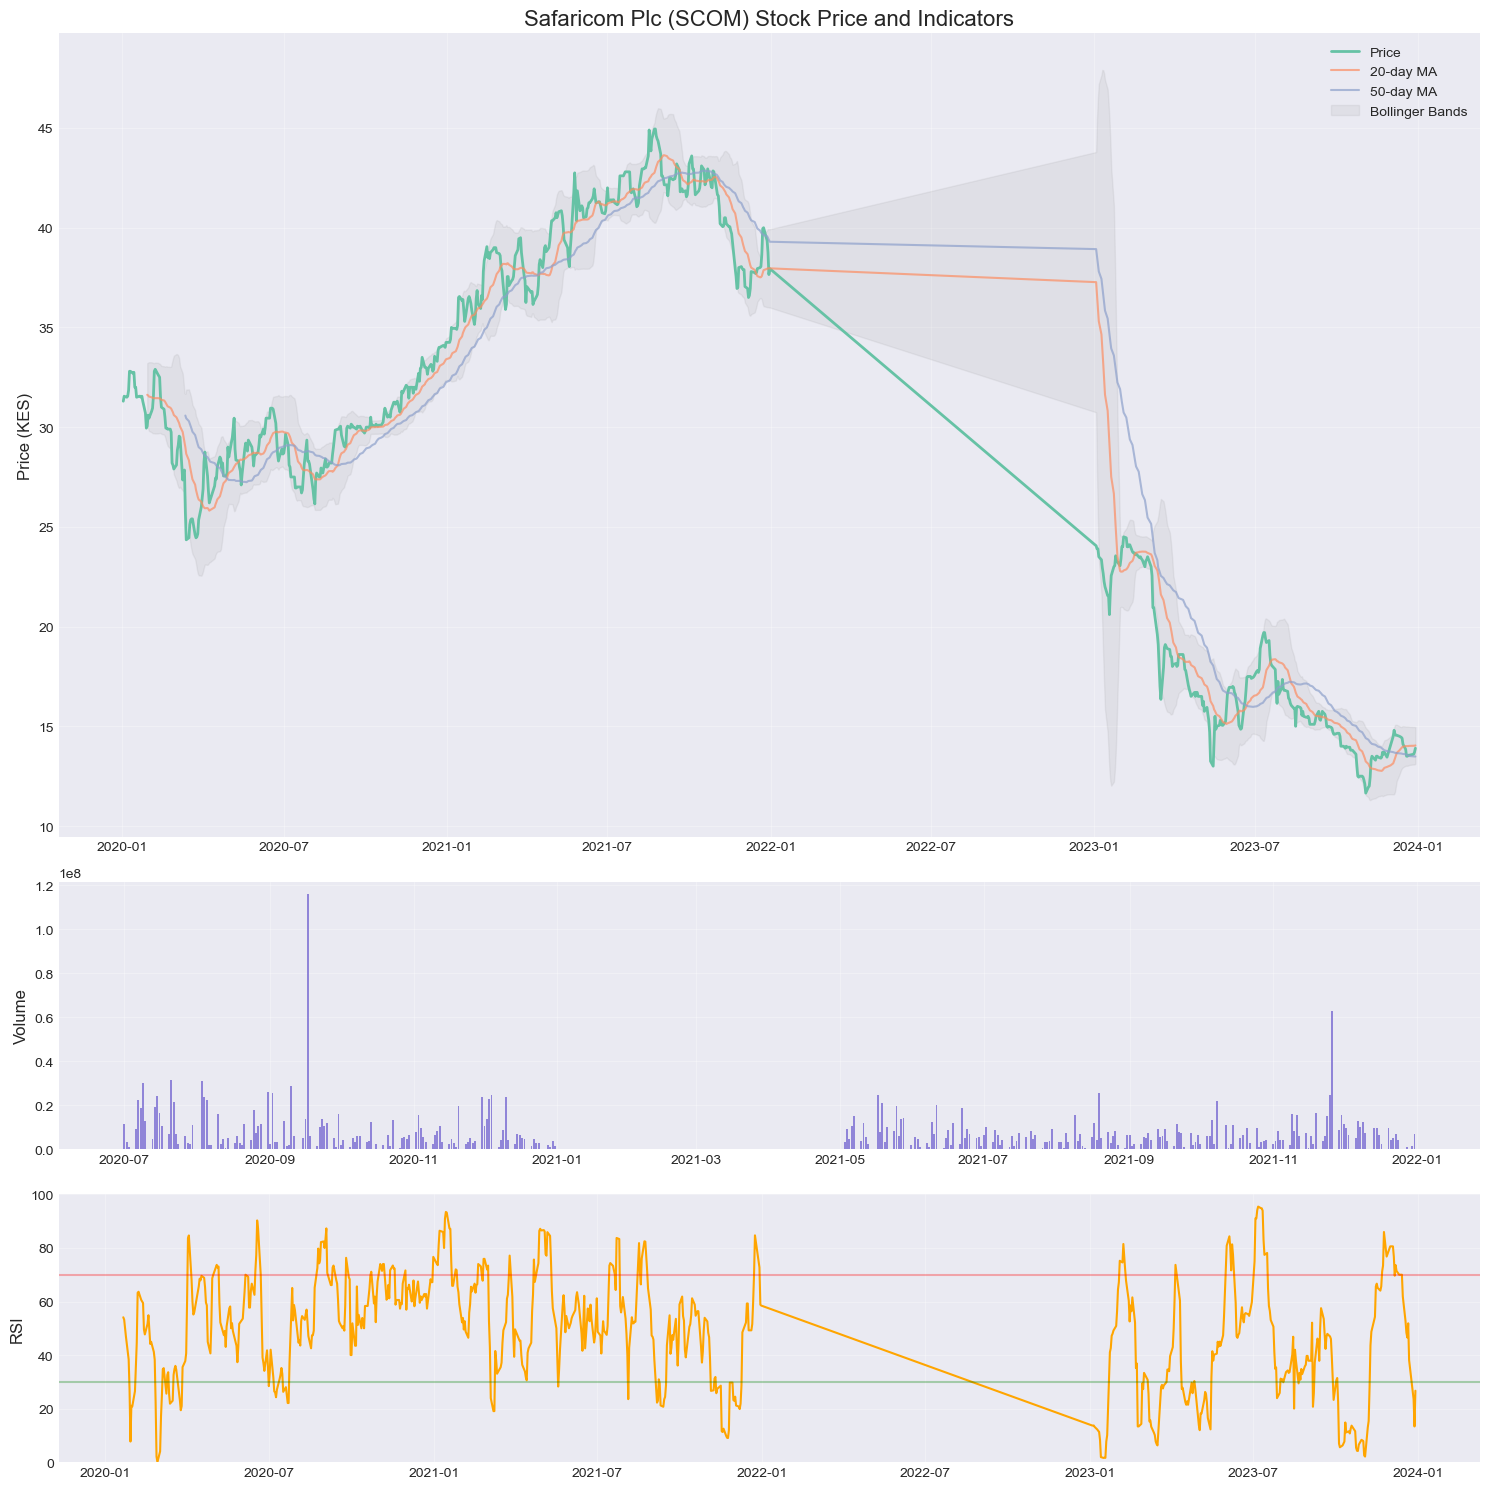

In [4]:
def analyze_stock_trends(data, stock_code, start_date=None, end_date=None):
    """Analyze and visualize trends for a specific stock"""
    # Get stock data
    stock_data = loader.get_stock_data(stock_code, start_date, end_date)
    
    if stock_data is None or stock_data.empty:
        print(f"No data available for {stock_code}")
        return None
    
    # Get stock name
    stock_name = stock_data['name'].iloc[0] if 'name' in stock_data.columns else stock_code
    
    # Calculate additional metrics
    stock_data = loader.calculate_technical_indicators(stock_data)
    
    # Create plot
    fig, axes = plt.subplots(3, 1, figsize=(15, 15), gridspec_kw={'height_ratios': [3, 1, 1]})
    
    # Plot 1: Price and Moving Averages
    axes[0].plot(stock_data['date'], stock_data['day_price'], label='Price', linewidth=2)
    axes[0].plot(stock_data['date'], stock_data['ma20'], label='20-day MA', alpha=0.7)
    axes[0].plot(stock_data['date'], stock_data['ma50'], label='50-day MA', alpha=0.7)
    axes[0].fill_between(stock_data['date'], stock_data['bb_lower'], stock_data['bb_upper'], alpha=0.1, color='gray', label='Bollinger Bands')
    
    axes[0].set_title(f'{stock_name} ({stock_code}) Stock Price and Indicators', fontsize=16)
    axes[0].set_ylabel('Price (KES)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Volume
    if 'volume' in stock_data.columns:
        axes[1].bar(stock_data['date'], stock_data['volume'], alpha=0.7, color='slateblue')
        axes[1].set_ylabel('Volume', fontsize=12)
        axes[1].grid(True, alpha=0.3)
    
    # Plot 3: RSI
    axes[2].plot(stock_data['date'], stock_data['rsi14'], color='orange', label='RSI (14)')
    axes[2].axhline(y=70, color='red', linestyle='-', alpha=0.3)
    axes[2].axhline(y=30, color='green', linestyle='-', alpha=0.3)
    axes[2].set_ylabel('RSI', fontsize=12)
    axes[2].set_ylim(0, 100)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return processed data for further analysis
    return stock_data

# %%
# Let's analyze Safaricom (SCOM) as an example
safaricom_data = analyze_stock_trends(combined_data, 'SCOM', '2020-01-01', '2023-12-31')

# %%
# Let's compare a few major stocks in the NSE
def compare_stocks(data, stock_codes, start_date=None, end_date=None):
    """Compare multiple stocks' performance"""
    plt.figure(figsize=(15, 8))
    
    for stock_code in stock_codes:
        # Get stock data
        stock_data = loader.get_stock_data(stock_code, start_date, end_date)
        
        if stock_data is None or stock_data.empty:
            print(f"No data available for {stock_code}")
            continue
        
        # Get stock name
        stock_name = stock_data['name'].iloc[0] if 'name' in stock_data.columns else stock_code
        
        # Normalize prices to 100 at the start for fair comparison
        first_price = stock_data['day_price'].iloc[0]
        normalized_prices = stock_data['day_price'] / first_price * 100
        
        # Plot normalized prices
        plt.plot(stock_data['date'], normalized_prices, label=f'{stock_name} ({stock_code})', linewidth=2)
    
    plt.title('Comparative Stock Performance (Normalized to 100)', fontsize=16)
    plt.ylabel('Normalized Price', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

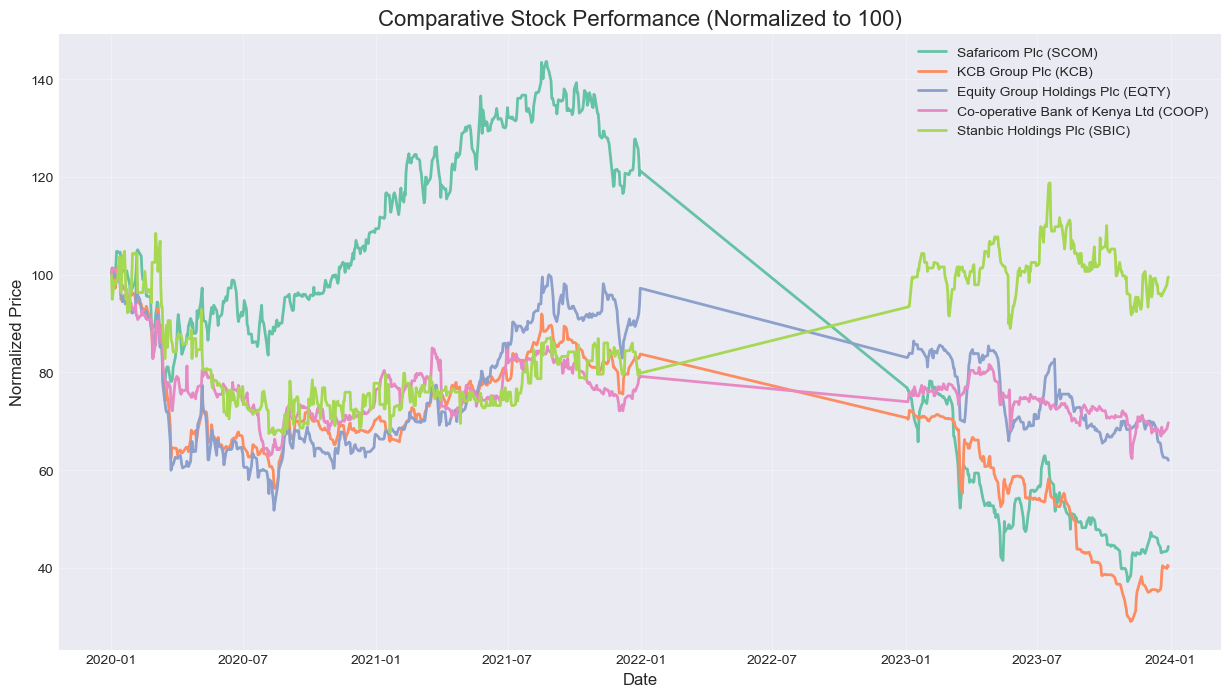

In [5]:
# Compare top banks and telecom stocks
compare_stocks(combined_data, ['SCOM', 'KCB', 'EQTY', 'COOP', 'SBIC'], '2020-01-01', '2023-12-31')

In [6]:
# Analyze correlation between different stocks
def analyze_stock_correlations(data, stock_codes, start_date=None, end_date=None):
    """Analyze correlations between different stocks"""
    # Create a dataframe to store daily prices for each stock
    price_df = pd.DataFrame()
    
    for stock_code in stock_codes:
        # Get stock data
        stock_data = loader.get_stock_data(stock_code, start_date, end_date)
        
        if stock_data is None or stock_data.empty:
            print(f"No data available for {stock_code}")
            continue
        
        # Add price data
        price_df[stock_code] = stock_data.set_index('date')['day_price']
    
    # Calculate correlation matrix
    correlation_matrix = price_df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Stock Price Correlation Matrix', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

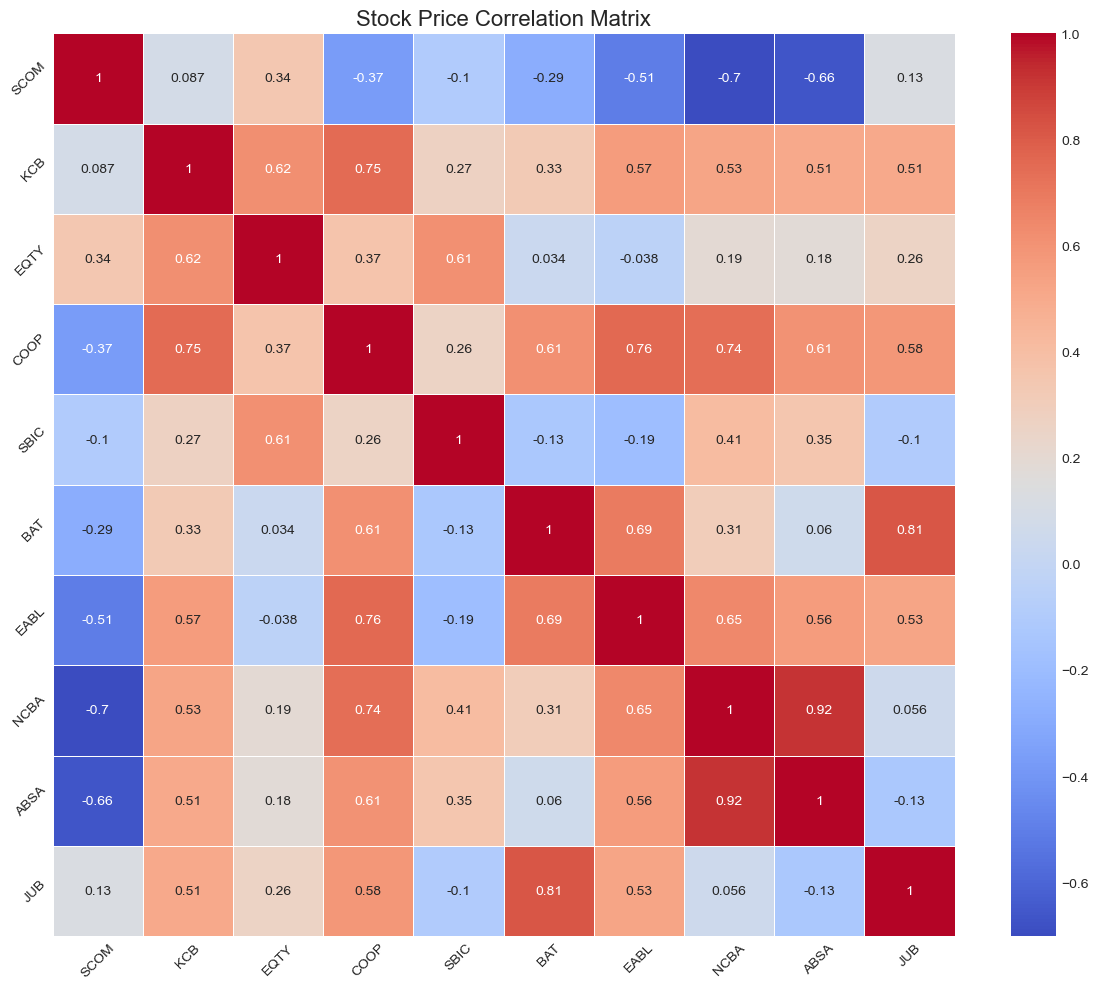

In [7]:
# Analyze correlations among top NSE stocks
correlation_matrix = analyze_stock_correlations(
    combined_data, 
    ['SCOM', 'KCB', 'EQTY', 'COOP', 'SBIC', 'BAT', 'EABL', 'NCBA', 'ABSA', 'JUB']
)

Missing values in target column: 0
Training data size: (1166, 21)
Testing data size: (292, 21)


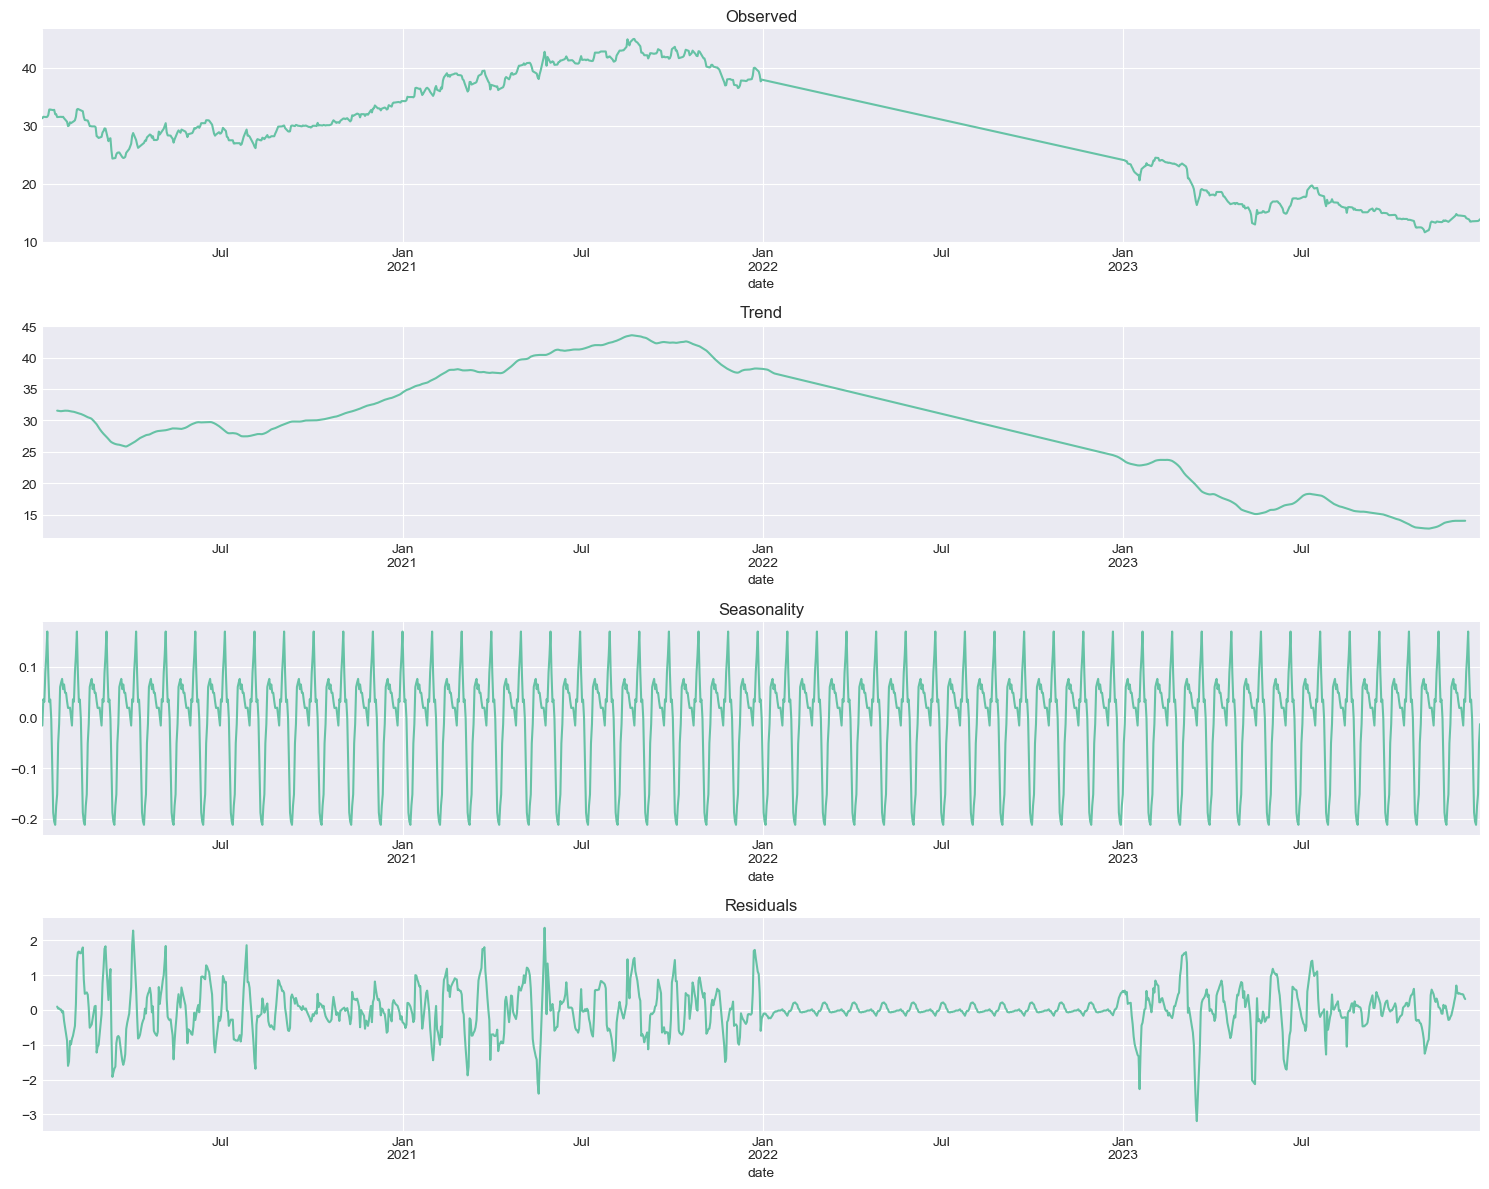


Augmented Dickey-Fuller Test:
ADF Statistic: 0.003225742267599001
p-value: 0.9587980410889307
Critical Values:
	1%: -3.434858527373781
	5%: -2.8635312133080046
	10%: -2.567830105465636
The time series is not stationary

After differencing:
ADF Statistic: -17.939659697364426
p-value: 2.8637272215927083e-30
The differenced time series is stationary


In [11]:
def prepare_time_series_data(stock_data, target_column='day_price', test_size=0.2):
    """Prepare time series data for forecasting"""
    # Ensure data is sorted by date
    stock_data = stock_data.sort_values('date')
    
    # Set date as index for time series analysis
    ts_data = stock_data.set_index('date')
    
    # Check for and handle missing values
    print(f"Missing values in target column: {ts_data[target_column].isna().sum()}")
    ts_data = ts_data.dropna(subset=[target_column])
    
    # Select only numeric columns for resampling
    numeric_cols = ts_data.select_dtypes(include=['number']).columns
    ts_data_numeric = ts_data[numeric_cols]
    
    # Resample to ensure regular time series (daily)
    # This is important for time series models like ARIMA
    ts_data_resampled = ts_data_numeric.resample('D').mean()
    ts_data_resampled = ts_data_resampled.interpolate(method='time')
    
    # Perform time series decomposition
    decomposition = sm.tsa.seasonal_decompose(ts_data_resampled[target_column], model='additive', period=30)
    
    # Create train/test split
    train_size = int(len(ts_data_resampled) * (1 - test_size))
    train_data = ts_data_resampled.iloc[:train_size]
    test_data = ts_data_resampled.iloc[train_size:]
    
    print(f"Training data size: {train_data.shape}")
    print(f"Testing data size: {test_data.shape}")
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
    decomposition.resid.plot(ax=axes[3], title='Residuals')
    plt.tight_layout()
    plt.show()
    
    # Check stationarity using Augmented Dickey-Fuller test
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(ts_data_resampled[target_column].dropna())
    print('\nAugmented Dickey-Fuller Test:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    if result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")
        # If not stationary, take difference
        ts_data_resampled['price_diff'] = ts_data_resampled[target_column].diff()
        # Check stationarity again
        result = adfuller(ts_data_resampled['price_diff'].dropna())
        print('\nAfter differencing:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        if result[1] <= 0.05:
            print("The differenced time series is stationary")
        else:
            print("The differenced time series is still not stationary")
    
    return {
        'original_data': stock_data,
        'ts_data': ts_data_resampled,
        'train_data': train_data,
        'test_data': test_data,
        'decomposition': decomposition,
        'is_stationary': result[1] <= 0.05
    }

# Let's prepare time series data for Safaricom
if safaricom_data is not None:
    safaricom_ts = prepare_time_series_data(safaricom_data)



In [12]:
def create_features_for_ml(ts_data, target_column='day_price', lag_days=[1, 2, 3, 5, 10, 20]):
    """Create features for machine learning models"""
    # Create a copy to avoid modifying the original
    data = ts_data.copy()
    
    # Create lag features
    for lag in lag_days:
        data[f'lag_{lag}'] = data[target_column].shift(lag)
    
    # Create rolling mean features
    data['rolling_mean_5'] = data[target_column].rolling(window=5).mean()
    data['rolling_mean_20'] = data[target_column].rolling(window=20).mean()
    
    # Create rolling standard deviation (volatility) features
    data['rolling_std_5'] = data[target_column].rolling(window=5).std()
    data['rolling_std_20'] = data[target_column].rolling(window=20).std()
    
    # Create day of week and month features
    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    # Create target variable (next day's price)
    data['target'] = data[target_column].shift(-1)
    
    # Drop rows with NaN values
    data = data.dropna()
    
    return data

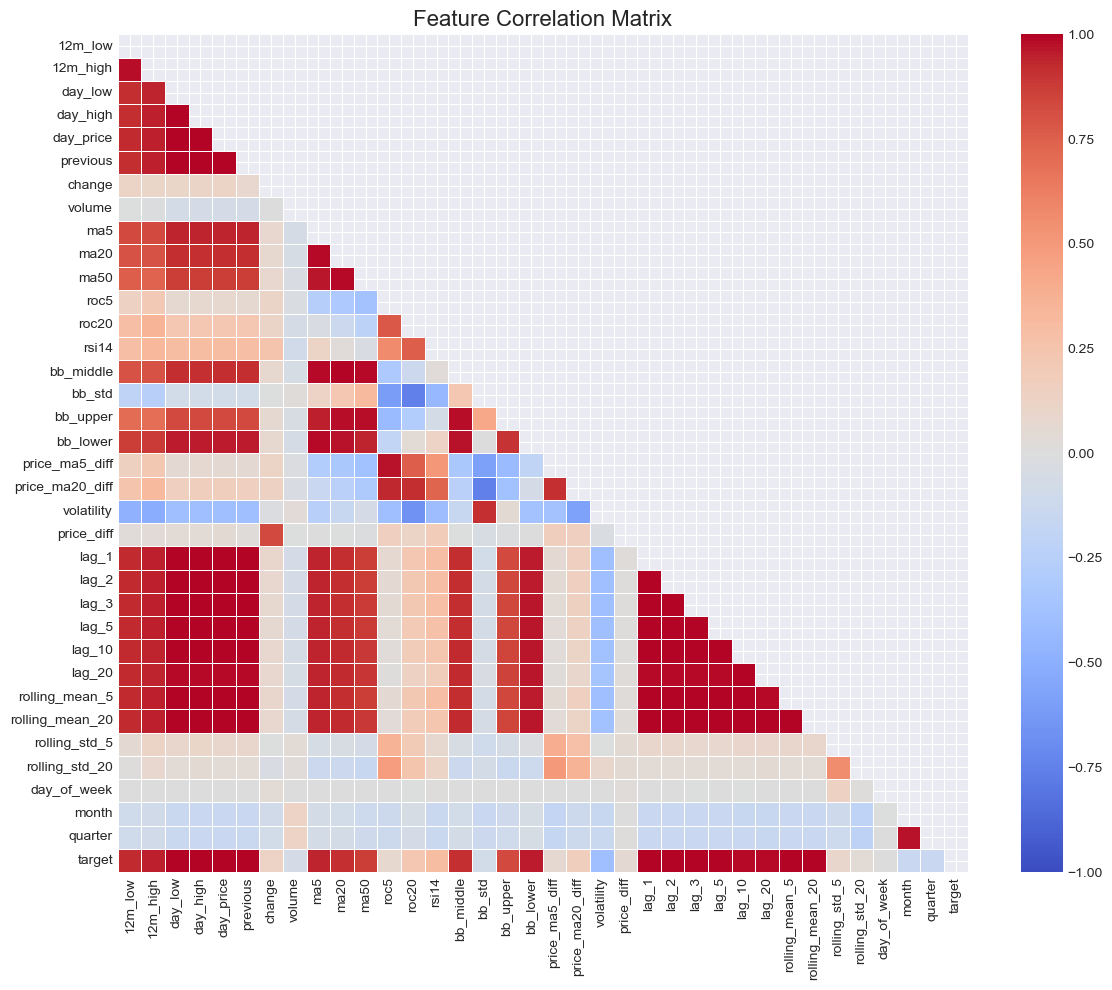

X_train shape: (985, 34)
X_test shape: (291, 34)


In [13]:
if 'ts_data' in safaricom_ts:
    # Create features for machine learning models
    safaricom_features = create_features_for_ml(safaricom_ts['ts_data'])
    
    # Display feature correlations
    plt.figure(figsize=(12, 10))
    corr_matrix = safaricom_features.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Split into features (X) and target (y)
    X = safaricom_features.drop(['target', 'day_price'], axis=1)
    y = safaricom_features['target']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create train-test split
    train_idx = safaricom_features.index < safaricom_ts['test_data'].index[0]
    X_train, X_test = X_scaled[train_idx], X_scaled[~train_idx]
    y_train, y_test = y[train_idx], y[~train_idx]
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")

In [19]:
def build_time_series_models(ts_data, train_data, test_data, target_column='day_price'):
    """Build and evaluate time series forecasting models"""
    results = {}
    
    # Get the actual test values for comparison
    y_test = test_data[target_column]
    
    # 1. Auto ARIMA Model
    print("Training Auto ARIMA model...")
    try:
        auto_arima_model = pm.auto_arima(
            train_data[target_column],
            seasonal=True,
            m=5,  # Assuming 5-day business week
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore",
            max_p=5, max_d=2, max_q=5,
            max_P=2, max_D=1, max_Q=2,
        )
        
        # Forecast
        n_periods = len(test_data)
        arima_forecast = auto_arima_model.predict(n_periods=n_periods)
        
        # Create forecast series with test index
        arima_forecast = pd.Series(arima_forecast, index=test_data.index)
        
        # Calculate metrics
        arima_mse = mean_squared_error(y_test, arima_forecast)
        arima_rmse = np.sqrt(arima_mse)
        arima_mae = mean_absolute_error(y_test, arima_forecast)
        
        results['auto_arima'] = {
            'forecast': arima_forecast,
            'mse': arima_mse,
            'rmse': arima_rmse,
            'mae': arima_mae,
            'model': auto_arima_model
        }
        
        print(f"Auto ARIMA - MSE: {arima_mse:.4f}, RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}")
        print(f"Best ARIMA Order: {auto_arima_model.order}")
        if auto_arima_model.seasonal_order:
            print(f"Seasonal Order: {auto_arima_model.seasonal_order}")
            
    except Exception as e:
        print(f"Error training Auto ARIMA model: {e}")
    
    # 2. Exponential Smoothing
    print("\nTraining Exponential Smoothing model...")
    try:
        exp_smoothing = ExponentialSmoothing(
            train_data[target_column],
            trend='add',
            seasonal='add',
            seasonal_periods=5  # Assuming 5-day business week
        ).fit()
        
        # Forecast
        es_forecast = exp_smoothing.forecast(len(test_data))
        
        # Create forecast series with test index
        es_forecast = pd.Series(es_forecast, index=test_data.index)
        
        # Calculate metrics
        es_mse = mean_squared_error(y_test, es_forecast)
        es_rmse = np.sqrt(es_mse)
        es_mae = mean_absolute_error(y_test, es_forecast)
        
        results['exp_smoothing'] = {
            'forecast': es_forecast,
            'mse': es_mse,
            'rmse': es_rmse,
            'mae': es_mae,
            'model': exp_smoothing
        }
        
        print(f"Exponential Smoothing - MSE: {es_mse:.4f}, RMSE: {es_rmse:.4f}, MAE: {es_mae:.4f}")
        
    except Exception as e:
        print(f"Error training Exponential Smoothing model: {e}")

# Plot forecasts vs actual
    plt.figure(figsize=(15, 8))
    plt.plot(train_data.index, train_data[target_column], label='Training Data', color='blue')
    plt.plot(test_data.index, test_data[target_column], label='Actual Test Data', color='green')
    
    for model_name, model_results in results.items():
        plt.plot(test_data.index, model_results['forecast'], label=f'{model_name} Forecast', 
                 linestyle='--', alpha=0.7)
    
    plt.title('Time Series Forecasting Models Comparison', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (KES)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

Training Auto ARIMA model...


Auto ARIMA - MSE: 63.8286, RMSE: 7.9893, MAE: 6.5650
Best ARIMA Order: (4, 2, 0)
Seasonal Order: (1, 0, 2, 5)

Training Exponential Smoothing model...
Exponential Smoothing - MSE: 12.9795, RMSE: 3.6027, MAE: 3.1064


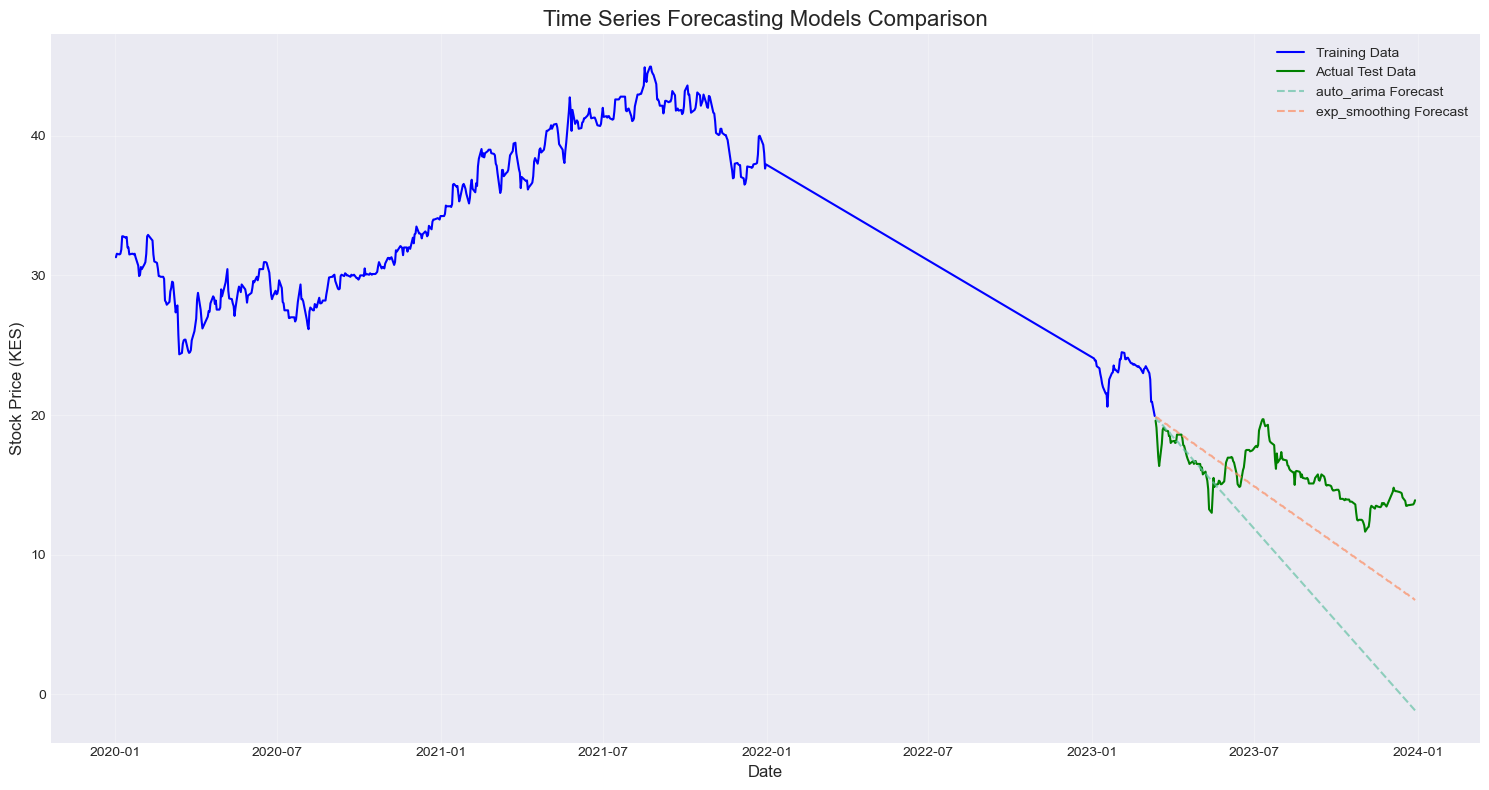

In [20]:
# Build time series models for Safaricom
if 'ts_data' in safaricom_ts:
    ts_models = build_time_series_models(
        safaricom_ts['ts_data'],
        safaricom_ts['train_data'],
        safaricom_ts['test_data']
    )

In [22]:
def build_ml_models(X_train, X_test, y_train, y_test, feature_names):
    """Build and evaluate machine learning models"""
    results = {}
    
    # 1. Linear Regression
    print("Training Linear Regression model...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    
    lr_mse = mean_squared_error(y_test, lr_pred)
    lr_rmse = np.sqrt(lr_mse)
    lr_mae = mean_absolute_error(y_test, lr_pred)
    lr_r2 = r2_score(y_test, lr_pred)
    
    results['linear_regression'] = {
        'predictions': lr_pred,
        'mse': lr_mse,
        'rmse': lr_rmse,
        'mae': lr_mae,
        'r2': lr_r2,
        'model': lr_model
    }
    
    print(f"Linear Regression - MSE: {lr_mse:.4f}, RMSE: {lr_rmse:.4f}, MAE: {lr_mae:.4f}, R²: {lr_r2:.4f}")
    
    # Feature importance for Linear Regression
    lr_importance = pd.Series(lr_model.coef_, index=feature_names).sort_values(ascending=False)
    print("\nLinear Regression Feature Importance:")
    print(lr_importance.head(10))
    
    # 2. Random Forest
    print("\nTraining Random Forest model...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    
    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_rmse = np.sqrt(rf_mse)
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_r2 = r2_score(y_test, rf_pred)
    
    results['random_forest'] = {
        'predictions': rf_pred,
        'mse': rf_mse,
        'rmse': rf_rmse,
        'mae': rf_mae,
        'r2': rf_r2,
        'model': rf_model
    }
    
    print(f"Random Forest - MSE: {rf_mse:.4f}, RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")
    
    # Feature importance for Random Forest
    rf_importance = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)
    print("\nRandom Forest Feature Importance:")
    print(rf_importance.head(10))
    
 # Gradient Boosting
    print("\nTraining Gradient Boosting model...")
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)
    gb_pred = gb_model.predict(X_test)
    
    gb_mse = mean_squared_error(y_test, gb_pred)
    gb_rmse = np.sqrt(gb_mse)
    gb_mae = mean_absolute_error(y_test, gb_pred)
    gb_r2 = r2_score(y_test, gb_pred)
    
    results['gradient_boosting'] = {
        'predictions': gb_pred,
        'mse': gb_mse,
        'rmse': gb_rmse,
        'mae': gb_mae,
        'r2': gb_r2,
        'model': gb_model
    }
    
    print(f"Gradient Boosting - MSE: {gb_mse:.4f}, RMSE: {gb_rmse:.4f}, MAE: {gb_mae:.4f}, R²: {gb_r2:.4f}")
    
    # Feature importance for Gradient Boosting
    gb_importance = pd.Series(gb_model.feature_importances_, index=feature_names).sort_values(ascending=False)
    print("\nGradient Boosting Feature Importance:")
    print(gb_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    
    # Get top 10 features
    top_features = gb_importance.head(10).index
    
    # Create a dataframe with feature importances from all models
    importance_df = pd.DataFrame({
        'Linear Regression': lr_importance.reindex(top_features).abs(),
        'Random Forest': rf_importance.reindex(top_features),
        'Gradient Boosting': gb_importance.reindex(top_features)
    })
    
    importance_df.plot(kind='barh', figsize=(12, 8))
    plt.title('Feature Importance Comparison Across Models', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted
    test_dates = y_test.index
    plt.figure(figsize=(15, 8))
    plt.plot(test_dates, y_test, label='Actual', color='green')
    plt.plot(test_dates, lr_pred, label='Linear Regression', linestyle='--', alpha=0.7)
    plt.plot(test_dates, rf_pred, label='Random Forest', linestyle='--', alpha=0.7)
    plt.plot(test_dates, gb_pred, label='Gradient Boosting', linestyle='--', alpha=0.7)
    
    plt.title('ML Models: Actual vs Predicted Stock Prices', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (KES)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

Training Linear Regression model...
Linear Regression - MSE: 0.1551, RMSE: 0.3938, MAE: 0.3065, R²: 0.9553

Linear Regression Feature Importance:
day_high          2.987832
day_low           2.422582
rolling_mean_5    1.952862
previous          1.596997
lag_2             1.043454
volatility        0.387688
lag_10            0.354957
bb_lower          0.345000
bb_middle         0.252102
ma20              0.252102
dtype: float64

Training Random Forest model...
Random Forest - MSE: 30.6342, RMSE: 5.5348, MAE: 5.2102, R²: -7.8244

Random Forest Feature Importance:
day_low           0.660461
day_high          0.185462
previous          0.090873
lag_1             0.024920
rolling_mean_5    0.017718
lag_2             0.008070
12m_low           0.002010
lag_20            0.001703
lag_10            0.001507
12m_high          0.001368
dtype: float64

Training Gradient Boosting model...
Gradient Boosting - MSE: 27.6672, RMSE: 5.2600, MAE: 4.9200, R²: -6.9697

Gradient Boosting Feature Importance

<Figure size 1200x800 with 0 Axes>

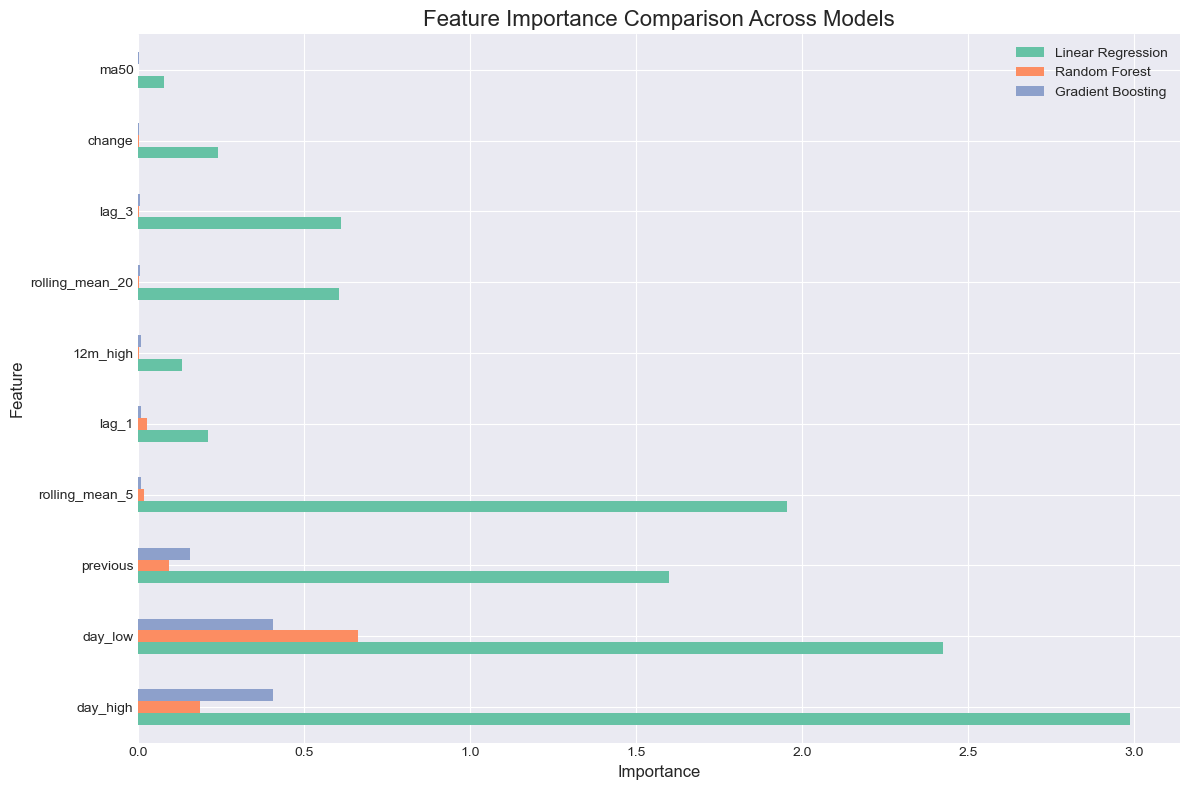

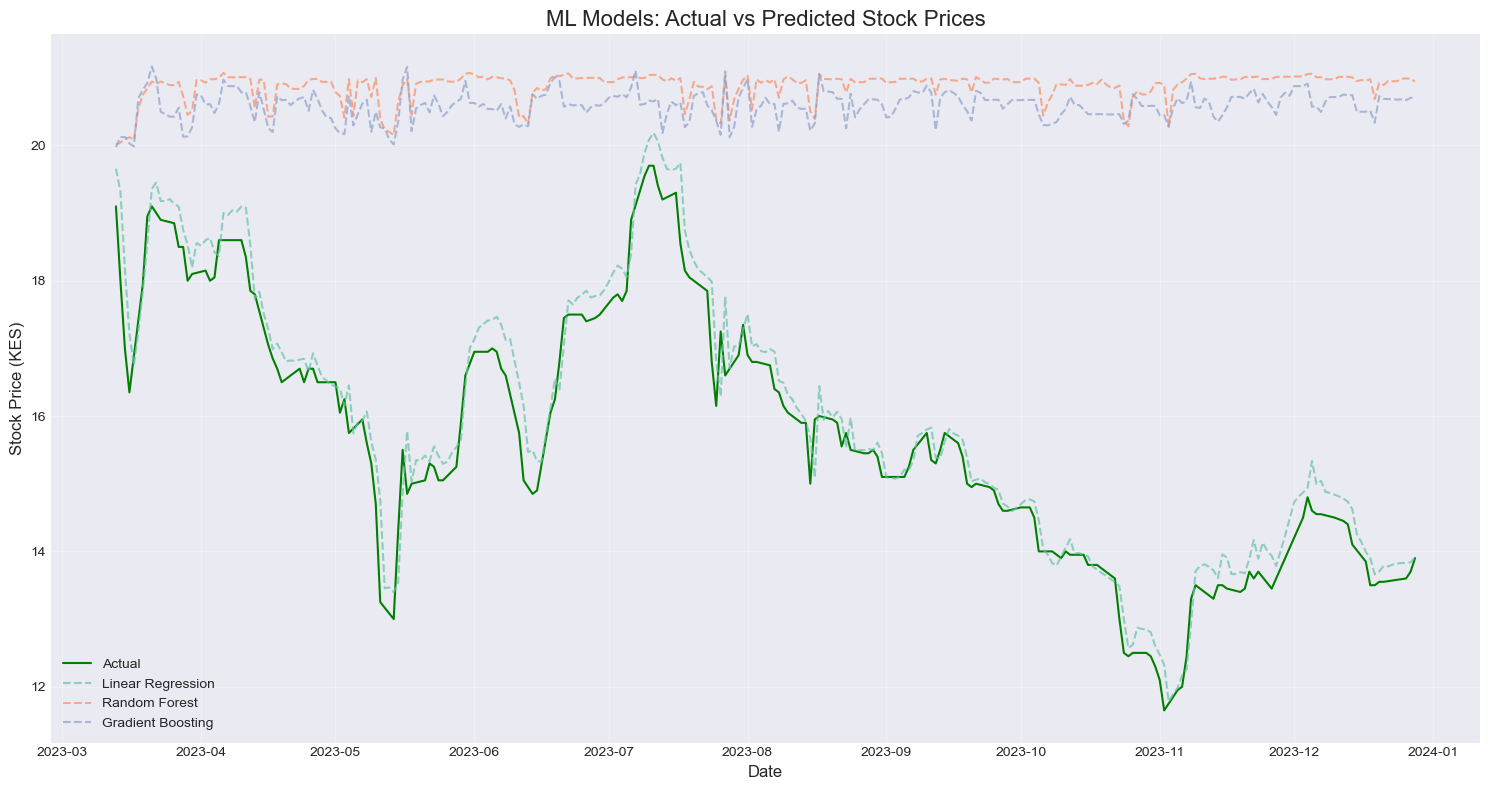

In [23]:
# Build ML models for Safaricom
if 'X_train' in locals() and 'y_train' in locals():
    ml_models = build_ml_models(X_train, X_test, y_train, y_test, X.columns)

# %%
def prepare_lstm_data(ts_data, target_column='day_price', sequence_length=10, test_size=0.2):
    """Prepare data for LSTM model"""
    # Create a copy to avoid modifying the original
    data = ts_data.copy()
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[target_column].values.reshape(-1, 1))
    
    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i+sequence_length, 0])
        y.append(scaled_data[i+sequence_length, 0])
    
    X, y = np.array(X), np.array(y)
    
    # Reshape for LSTM [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Split into train and test sets
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"LSTM X_train shape: {X_train.shape}")
    print(f"LSTM X_test shape: {X_test.shape}")
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'sequence_length': sequence_length,
        'test_dates': ts_data.index[sequence_length+train_size:]
    }

def build_lstm_model(lstm_data):
    """Build and train LSTM model"""
    # Unpack data
    X_train = lstm_data['X_train']
    y_train = lstm_data['y_train']
    X_test = lstm_data['X_test']
    y_test = lstm_data['y_test']
    scaler = lstm_data['scaler']
    test_dates = lstm_data['test_dates']
    
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    # Make predictions
    lstm_pred = model.predict(X_test)
    
    # Inverse transform the predictions and actual values
    lstm_pred = scaler.inverse_transform(lstm_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    lstm_mse = mean_squared_error(y_test_inv, lstm_pred)
    lstm_rmse = np.sqrt(lstm_mse)
    lstm_mae = mean_absolute_error(y_test_inv, lstm_pred)
    
    print(f"LSTM - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")
    
    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 8))
    plt.plot(test_dates, y_test_inv, label='Actual', color='green')
    plt.plot(test_dates, lstm_pred, label='LSTM Prediction', color='red', linestyle='--')
    
    plt.title('LSTM: Actual vs Predicted Stock Prices', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (KES)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'history': history,
        'predictions': lstm_pred,
        'mse': lstm_mse,
        'rmse': lstm_rmse,
        'mae': lstm_mae
    }

LSTM X_train shape: (1158, 10, 1)
LSTM X_test shape: (290, 10, 1)
Epoch 1/100
37/37 [==============================] - 11s 74ms/step - loss: 0.0671 - val_loss: 0.0358
Epoch 2/100
37/37 [==============================] - 1s 36ms/step - loss: 0.0068 - val_loss: 0.0163
Epoch 3/100
37/37 [==============================] - 1s 25ms/step - loss: 0.0045 - val_loss: 0.0078
Epoch 4/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 5/100
37/37 [==============================] - 1s 27ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 6/100
37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/100
37/37 [==============================] - 1s 26ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 8/100
37/37 [==============================] - 1s 29ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 9/100
37/37 [==============================] - 1s 33ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/100
37/37 [=============

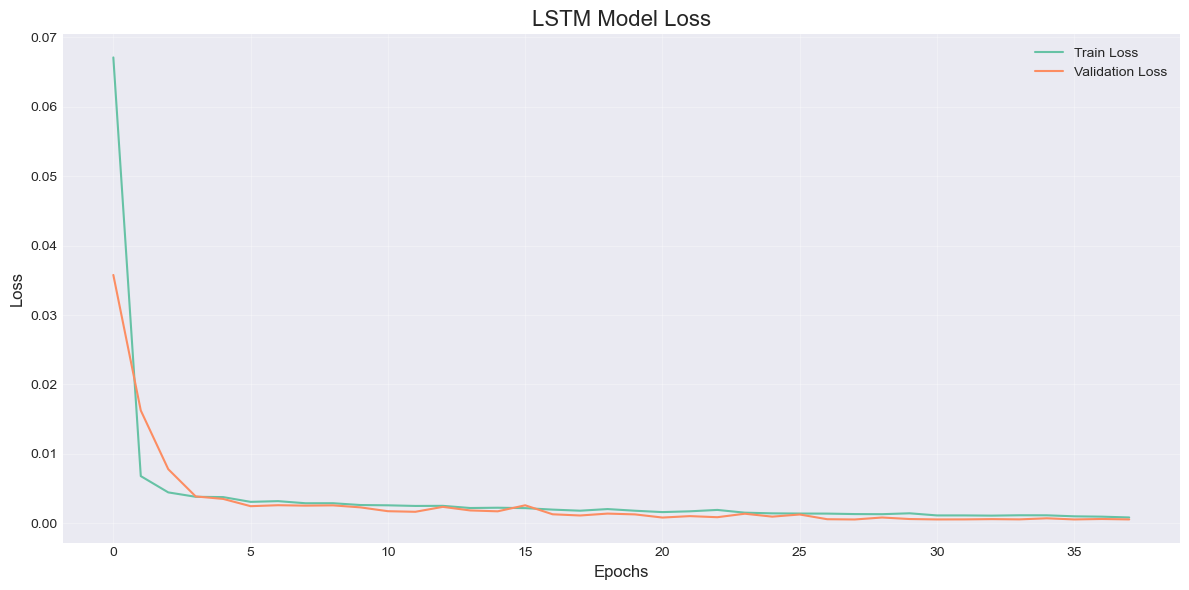

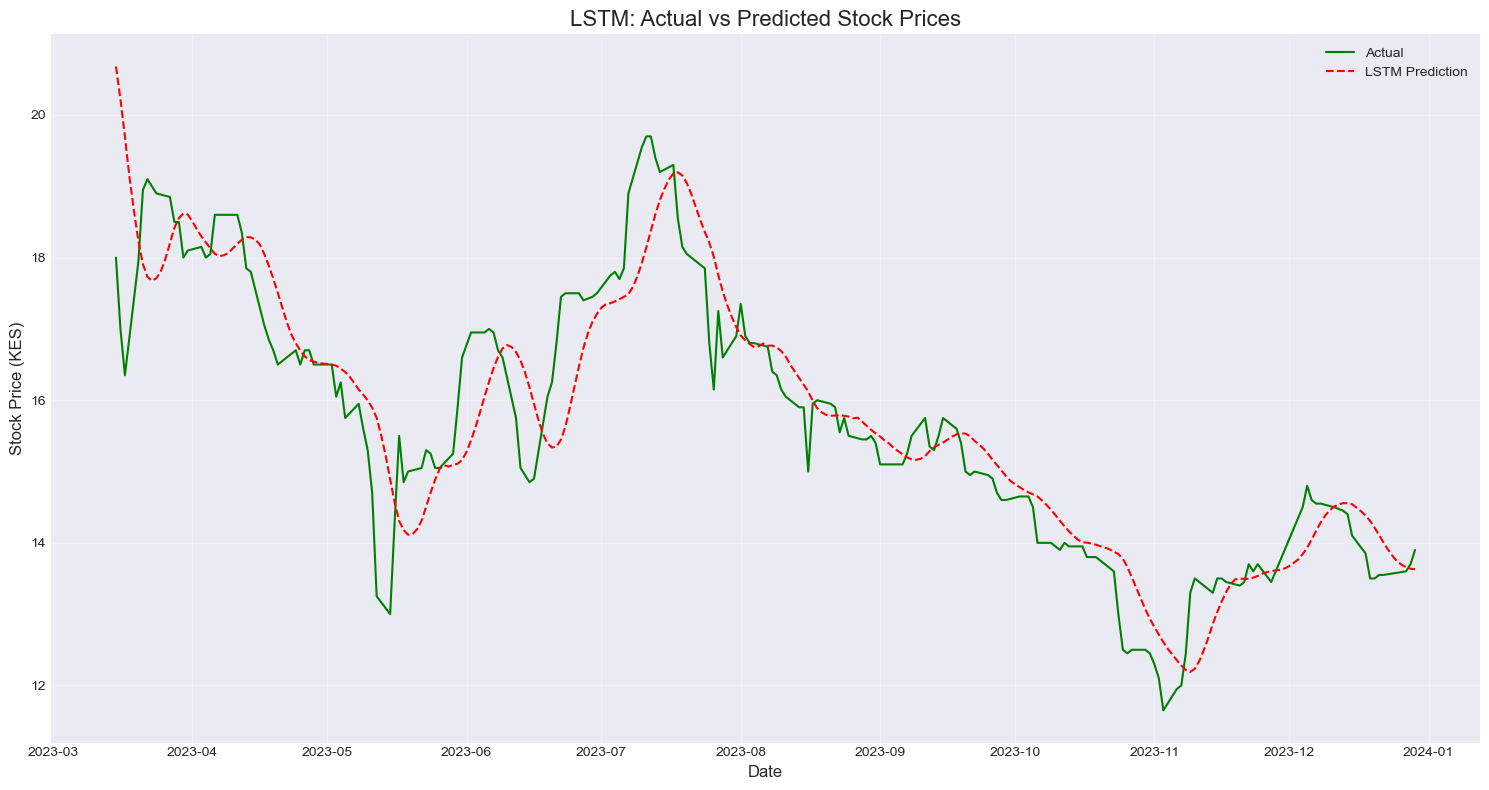

In [24]:
# Build LSTM model for Safaricom
if 'ts_data' in safaricom_ts:
    # Prepare data for LSTM
    lstm_data = prepare_lstm_data(safaricom_ts['ts_data'][['day_price']])
    
    # Build and train LSTM model
    lstm_model = build_lstm_model(lstm_data)

In [ ]:
\

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 134)

In [10]:
def compare_models(stock_code, ts_models, ml_models, lstm_model, lstm_data):
    """Compare all models and select the best one"""
    
    # Collect all model results
    model_metrics = []
    
    # Add time series models
    for model_name, model_results in ts_models.items():
        model_metrics.append({
            'Model Type': 'Time Series',
            'Model Name': model_name,
            'MSE': model_results['mse'],
            'RMSE': model_results['rmse'],
            'MAE': model_results['mae']
        })
    
    # Add ML models
    for model_name, model_results in ml_models.items():
        model_metrics.append({
            'Model Type': 'Machine Learning',
            'Model Name': model_name,
            'MSE': model_results['mse'],
            'RMSE': model_results['rmse'],
            'MAE': model_results['mae'],
            'R²': model_results['r2']
        })
    
    # Add LSTM model
    model_metrics.append({
        'Model Type': 'Deep Learning',
        'Model Name': 'LSTM',
        'MSE': lstm_model['mse'],
        'RMSE': lstm_model['rmse'],
        'MAE': lstm_model['mae']
    })
    
    # Convert to DataFrame for easy comparison
    metrics_df = pd.DataFrame(model_metrics)
    
    # Sort by RMSE (lower is better)
    metrics_df = metrics_df.sort_values('RMSE')
    
    # Find best model
    best_model = metrics_df.iloc[0]
    print(f"Best model for {stock_code}: {best_model['Model Type']} - {best_model['Model Name']}")
    print(f"RMSE: {best_model['RMSE']:.4f}, MAE: {best_model['MAE']:.4f}")
    
    # Plot comparison of metrics
    plt.figure(figsize=(15, 6))
    
    # Plot RMSE for each model
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model Name', y='RMSE', hue='Model Type', data=metrics_df)
    plt.title('RMSE Comparison Across Models', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Plot MAE for each model
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model Name', y='MAE', hue='Model Type', data=metrics_df)
    plt.title('MAE Comparison Across Models', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()
    
    return metrics_df, best_model

# Compare all models
if 'ts_models' in locals() and 'ml_models' in locals() and 'lstm_model' in locals() and 'lstm_data' in locals():
    metrics_df, best_model = compare_models('SCOM', ts_models, ml_models, lstm_model, lstm_data)
    
def make_future_predictions(stock_code, best_model_info, ts_models, ml_models, lstm_model, 
                           lstm_data, loader, create_features_for_ml, forecast_days=30):
    """Make future predictions using the best model"""
    best_model_type = best_model_info['Model Type']
    best_model_name = best_model_info['Model Name']
    
    print(f"Making {forecast_days}-day forecast for {stock_code} using {best_model_type} - {best_model_name}...")
    
    # Get the latest data
    latest_data = loader.get_stock_data(stock_code)
    
    # Create a date range for future predictions
    last_date = latest_data['date'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='B')
    
    if best_model_type == 'Time Series':
        model_info = ts_models[best_model_name]
        model = model_info['model']
        
        # Make predictions
        if best_model_name == 'auto_arima':
            predictions = model.predict(n_periods=forecast_days)
        elif best_model_name == 'exp_smoothing':
            predictions = model.forecast(forecast_days)
        
        # Create forecast DataFrame
        forecast_df = pd.DataFrame({
            'date': future_dates,
            'forecast': predictions
        })
        
    elif best_model_type == 'Machine Learning':
        model_info = ml_models[best_model_name]
        model = model_info['model']
        
        # Need to create features for ML model
        # This is a simplified approach - in practice, we'd need to handle this more carefully
        latest_ts_data = latest_data.set_index('date').sort_index()
        
        # Calculate technical indicators
        latest_ts_data = loader.calculate_technical_indicators(latest_data)
        latest_ts_data = latest_ts_data.set_index('date')
        
        # Create features for ML
        ml_features = create_features_for_ml(latest_ts_data)
        
        # Get the last row of features
        last_features = ml_features.iloc[-1].drop(['target', 'day_price'])
        
        # Create empty prediction DataFrame
        forecast_df = pd.DataFrame(index=future_dates)
        forecast_df['forecast'] = np.nan
        
        # Predict one day at a time (iterative forecasting)
        for i in range(len(future_dates)):
            # Make prediction
            prediction = model.predict([last_features])[0]
            
            # Store prediction
            forecast_df.iloc[i, 0] = prediction
            
    elif best_model_type == 'Deep Learning':
        model = lstm_model['model']
        scaler = lstm_data['scaler']
        sequence_length = lstm_data['sequence_length']
        
        # Get the last sequence_length days of data
        last_sequence = latest_data['day_price'].values[-sequence_length:]
        
        # Scale the data
        last_sequence = scaler.transform(last_sequence.reshape(-1, 1))
        
        # Create empty prediction DataFrame
        forecast_df = pd.DataFrame(index=future_dates)
        forecast_df['forecast'] = np.nan
        
        # Make sequence predictions
        curr_sequence = last_sequence.reshape(1, sequence_length, 1)
        
        for i in range(len(future_dates)):
            # Make prediction
            prediction = model.predict(curr_sequence)[0][0]
            
            # Store prediction
            forecast_df.iloc[i, 0] = scaler.inverse_transform([[prediction]])[0][0]
            
            # Update sequence for next prediction
            curr_sequence = np.append(curr_sequence[:,1:,:], [[[prediction]]], axis=1)
    
    # Plot historical data and forecast
    plt.figure(figsize=(15, 8))
    
    # Plot historical data
    historical_plot_days = 90  # Show last 90 days of historical data
    hist_data = latest_data.sort_values('date').tail(historical_plot_days)
    plt.plot(hist_data['date'], hist_data['day_price'], label='Historical', color='blue')
    
    # Plot forecast
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red', linestyle='--')
    
    # Add confidence intervals (simplified)
    if best_model_type == 'Time Series':
        # Calculate standard deviation of historical data
        std_dev = hist_data['day_price'].std()
        
        # Add confidence intervals (±1 and ±2 standard deviations)
        plt.fill_between(
            forecast_df.index,
            forecast_df['forecast'] - std_dev,
            forecast_df['forecast'] + std_dev,
            color='red', alpha=0.2, label='68% Confidence Interval'
        )
        plt.fill_between(
            forecast_df.index,
            forecast_df['forecast'] - 2*std_dev,
            forecast_df['forecast'] + 2*std_dev,
            color='red', alpha=0.1, label='95% Confidence Interval'
        )
    
    plt.title(f'{stock_code} Stock Price Forecast ({forecast_days} days)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (KES)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return forecast_df

# Make future predictions
if 'best_model' in locals() and 'ts_models' in locals() and 'ml_models' in locals() and 'lstm_model' in locals() and 'lstm_data' in locals():
    forecast_df = make_future_predictions('SCOM', best_model, ts_models, ml_models, lstm_model, lstm_data, loader, create_features_for_ml, forecast_days=30)

In [11]:
def create_ensemble_forecast(stock_code, metrics_df, ts_models, ml_models, lstm_model, 
                            lstm_data, loader, create_features_for_ml, forecast_days=30):
    """
    Create an ensemble forecast by combining predictions from top 3 models
    weighted by their inverse RMSE (better models get higher weights)
    """
    # Select top 3 models based on RMSE
    top_models = metrics_df.sort_values('RMSE').head(3)
    
    # Get latest data
    latest_data = loader.get_stock_data(stock_code)
    
    # Create future dates
    last_date = latest_data['date'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='B')
    
    # Initialize ensemble forecast DataFrame
    ensemble_df = pd.DataFrame(index=future_dates)
    ensemble_df['forecast'] = 0.0
    
    # Calculate weights based on inverse RMSE (better models get higher weights)
    weights = (1 / top_models['RMSE'])
    weights = weights / weights.sum()  # Normalize to sum to 1
    
    print(f"Ensemble weights for {stock_code}:")
    for i, (idx, row) in enumerate(top_models.iterrows()):
        print(f"{row['Model Type']} - {row['Model Name']}: {weights.iloc[i]:.4f}")
    
    # Generate predictions from each model and add to ensemble
    for i, (idx, model_info) in enumerate(top_models.iterrows()):
        model_type = model_info['Model Type']
        model_name = model_info['Model Name']
        weight = weights.iloc[i]
        
        # Get predictions using the same approach as in make_future_predictions
        if model_type == 'Time Series':
            model = ts_models[model_name]['model']
            
            if model_name == 'auto_arima':
                predictions = model.predict(n_periods=forecast_days)
            elif model_name == 'exp_smoothing':
                predictions = model.forecast(forecast_days)
            
            # Add weighted predictions to ensemble
            ensemble_df['forecast'] += predictions * weight
            
        elif model_type == 'Machine Learning':
            model = ml_models[model_name]['model']
            
            # Calculate technical indicators
            latest_ts_data = loader.calculate_technical_indicators(latest_data)
            latest_ts_data = latest_ts_data.set_index('date')
            
            # Create features for ML
            ml_features = create_features_for_ml(latest_ts_data)
            
            # Get the last row of features
            last_features = ml_features.iloc[-1].drop(['target', 'day_price'])
            
            # Initialize predictions array
            predictions = np.zeros(len(future_dates))
            
            # Predict one day at a time (iterative forecasting)
            for j in range(len(future_dates)):
                # Make prediction
                prediction = model.predict([last_features])[0]
                predictions[j] = prediction
                
                # For simplicity, we're not updating features here
                # In a real implementation, we'd need to update technical indicators
            
            # Add weighted predictions to ensemble
            ensemble_df['forecast'] += predictions * weight
            
        elif model_type == 'Deep Learning':
            model = lstm_model['model']
            scaler = lstm_data['scaler']
            sequence_length = lstm_data['sequence_length']
            
            # Get the last sequence_length days of data
            last_sequence = latest_data['day_price'].values[-sequence_length:]
            
            # Scale the data
            last_sequence = scaler.transform(last_sequence.reshape(-1, 1))
            
            # Initialize predictions array
            predictions = np.zeros(len(future_dates))
            
            # Make sequence predictions
            curr_sequence = last_sequence.reshape(1, sequence_length, 1)
            
            for j in range(len(future_dates)):
                # Make prediction
                prediction = model.predict(curr_sequence)[0][0]
                
                # Store prediction (inverse transformed)
                predictions[j] = scaler.inverse_transform([[prediction]])[0][0]
                
                # Update sequence for next prediction
                curr_sequence = np.append(curr_sequence[:,1:,:], [[[prediction]]], axis=1)
            
            # Add weighted predictions to ensemble
            ensemble_df['forecast'] += predictions * weight
    
    # Calculate confidence intervals
    std_dev = latest_data['day_price'].tail(30).std()
    ensemble_df['upper_bound_68'] = ensemble_df['forecast'] + std_dev
    ensemble_df['lower_bound_68'] = ensemble_df['forecast'] - std_dev
    ensemble_df['upper_bound_95'] = ensemble_df['forecast'] + 2 * std_dev
    ensemble_df['lower_bound_95'] = ensemble_df['forecast'] - 2 * std_dev
    
    return ensemble_df

# Generate ensemble forecast if required variables exist
if 'metrics_df' in locals() and 'ts_models' in locals() and 'ml_models' in locals() and 'lstm_model' in locals() and 'lstm_data' in locals():
    ensemble_forecast = create_ensemble_forecast('SCOM', metrics_df, ts_models, ml_models, 
                                                lstm_model, lstm_data, loader, create_features_for_ml)

In [12]:
def backtest_models(stock_code, metrics_df, ts_models, ml_models, lstm_model, 
                   lstm_data, loader, create_features_for_ml, test_periods=30, backtest_runs=3):
    """
    Backtest the top models by testing predictions against known historical data
    """
    # Get all available data
    full_data = loader.get_stock_data(stock_code)
    full_data = full_data.sort_values('date')
    
    # Select top 3 models based on RMSE
    top_models = metrics_df.sort_values('RMSE').head(3)
    
    # Track performance across multiple backtest periods
    backtest_results = []
    
    # Run multiple backtests with different end dates
    for run in range(backtest_runs):
        # Select end point for this backtest
        # We go backwards from the end of the data
        end_idx = len(full_data) - (run * test_periods)
        
        if end_idx <= test_periods + 60:  # Ensure we have enough data
            continue
            
        backtest_end = full_data.iloc[end_idx - 1]['date']
        backtest_start = full_data.iloc[end_idx - test_periods - 1]['date']
        
        print(f"\nBacktest {run+1}: Testing predictions from {backtest_start} to {backtest_end}")
        
        # Split data into training and testing
        train_data = full_data[full_data['date'] < backtest_start]
        test_data = full_data[(full_data['date'] >= backtest_start) & (full_data['date'] <= backtest_end)]
        
        # Track predictions for this backtest period
        model_predictions = {}
        
        # Generate predictions for each model
        for _, model_info in top_models.iterrows():
            model_type = model_info['Model Type']
            model_name = model_info['Model Name']
            
            print(f"Backtesting {model_type} - {model_name}...")
            
            # Initialize predictions
            preds = []
            
            # For simplicity, we'll use a simplified approach here
            # In a real implementation, we would retrain models for each period
            
            if model_type == 'Time Series':
                if model_name == 'auto_arima':
                    # Use the already trained model to predict test period
                    model = ts_models[model_name]['model']
                    preds = model.predict(n_periods=len(test_data))
                elif model_name == 'exp_smoothing':
                    model = ts_models[model_name]['model']
                    preds = model.forecast(len(test_data))
                    
            elif model_type == 'Machine Learning':
                # For ML models, this is a simplification
                # We would need to recalculate features for each prediction
                model = ml_models[model_name]['model']
                preds = model.predict(create_features_for_ml(train_data.set_index('date')).drop(['target', 'day_price'], axis=1).iloc[-len(test_data):])
                
            elif model_type == 'Deep Learning':
                # For LSTM, this is a simplification
                model = lstm_model['model']
                scaler = lstm_data['scaler']
                sequence_length = lstm_data['sequence_length']
                
                # Get the last sequence from training data
                last_sequence = train_data['day_price'].values[-sequence_length:]
                last_sequence = scaler.transform(last_sequence.reshape(-1, 1))
                
                # Make predictions
                preds = []
                curr_sequence = last_sequence.reshape(1, sequence_length, 1)
                
                for i in range(len(test_data)):
                    prediction = model.predict(curr_sequence)[0][0]
                    preds.append(scaler.inverse_transform([[prediction]])[0][0])
                    curr_sequence = np.append(curr_sequence[:,1:,:], [[[prediction]]], axis=1)
            
            # Convert predictions to numpy array if needed
            if not isinstance(preds, np.ndarray):
                preds = np.array(preds)
                
            # Store predictions
            model_predictions[f"{model_type} - {model_name}"] = preds
            
            # Calculate and display metrics
            rmse = np.sqrt(mean_squared_error(test_data['day_price'].values, preds))
            mae = mean_absolute_error(test_data['day_price'].values, preds)
            
            print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}")
            
            # Store results
            backtest_results.append({
                'Run': run + 1,
                'Model': f"{model_type} - {model_name}",
                'RMSE': rmse,
                'MAE': mae,
                'Start Date': backtest_start,
                'End Date': backtest_end
            })
        
        # Create combined predictions plot
        plt.figure(figsize=(15, 8))
        
        # Plot actual prices
        plt.plot(test_data['date'], test_data['day_price'], label='Actual', linewidth=2)
        
        # Plot model predictions
        for model_name, preds in model_predictions.items():
            plt.plot(test_data['date'], preds, label=f"{model_name} Prediction", linestyle='--')
        
        plt.title(f'Backtest {run+1}: {stock_code} Price Predictions ({backtest_start} to {backtest_end})', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Stock Price (KES)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(backtest_results)
    
    # Calculate average performance by model
    avg_performance = results_df.groupby('Model')[['RMSE', 'MAE']].mean().reset_index()
    avg_performance = avg_performance.sort_values('RMSE')
    
    # Display average performance
    print("\nAverage Backtest Performance by Model:")
    print(avg_performance)
    
    # Plot average performance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='RMSE', data=avg_performance)
    plt.title('Average RMSE Across Backtest Periods', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results_df, avg_performance

# Run backtesting if required variables exist
if 'metrics_df' in locals() and 'ts_models' in locals() and 'ml_models' in locals() and 'lstm_model' in locals() and 'lstm_data' in locals():
    backtest_results, avg_performance = backtest_models('SCOM', metrics_df, ts_models, ml_models, 
                                                      lstm_model, lstm_data, loader, create_features_for_ml)

In [13]:
def plot_ensemble_forecast(stock_code, ensemble_df, loader, historical_days=90):
    """Plot the ensemble forecast with confidence intervals"""
    
    # Get latest data
    latest_data = loader.get_stock_data(stock_code)
    latest_data = latest_data.sort_values('date')
    
    # Get company name if available
    stock_name = latest_data['name'].iloc[0] if 'name' in latest_data.columns else stock_code
    
    # Plot historical data and forecast
    plt.figure(figsize=(15, 8))
    
    # Plot historical data
    hist_data = latest_data.tail(historical_days)
    plt.plot(hist_data['date'], hist_data['day_price'], label='Historical', color='blue', linewidth=2)
    
    # Plot forecast
    plt.plot(ensemble_df.index, ensemble_df['forecast'], label='Ensemble Forecast', color='red', linewidth=2, linestyle='--')
    
    # Add confidence intervals
    plt.fill_between(
        ensemble_df.index,
        ensemble_df['lower_bound_68'],
        ensemble_df['upper_bound_68'],
        color='red', alpha=0.2, label='68% Confidence Interval'
    )
    plt.fill_between(
        ensemble_df.index,
        ensemble_df['lower_bound_95'],
        ensemble_df['upper_bound_95'],
        color='red', alpha=0.1, label='95% Confidence Interval'
    )
    
    # Calculate forecast metrics
    last_price = hist_data['day_price'].iloc[-1]
    forecast_end = ensemble_df['forecast'].iloc[-1]
    percent_change = ((forecast_end / last_price) - 1) * 100
    
    # Get forecast trend
    forecast_trend = "upward" if percent_change > 0 else "downward"
    
    # Add annotations
    plt.annotate(f'Current: {last_price:.2f} KES', 
                 xy=(hist_data['date'].iloc[-1], last_price),
                 xytext=(10, 30), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    plt.annotate(f'Forecast: {forecast_end:.2f} KES ({percent_change:.2f}%)', 
                 xy=(ensemble_df.index[-1], forecast_end),
                 xytext=(10, 30), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    plt.title(f'{stock_name} ({stock_code}) Stock Price Forecast - {forecast_trend.capitalize()} Trend', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (KES)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return percent_change, forecast_trend

# Plot ensemble forecast if it exists
if 'ensemble_forecast' in locals():
    percent_change, forecast_trend = plot_ensemble_forecast('SCOM', ensemble_forecast, loader)

In [14]:
def generate_investment_recommendations(stock_code, ensemble_df, backtest_performance, 
                                       loader, risk_tolerance='moderate'):
    """
    Generate investment recommendations based on forecast and backtest performance
    
    Args:
        stock_code: Stock code to analyze
        ensemble_df: Ensemble forecast DataFrame
        backtest_performance: Backtest performance DataFrame
        loader: Data loader object
        risk_tolerance: User's risk tolerance ('conservative', 'moderate', 'aggressive')
        
    Returns:
        Dictionary with investment recommendations
    """
    # Get latest data
    latest_data = loader.get_stock_data(stock_code)
    latest_data = latest_data.sort_values('date')
    
    # Get company name if available
    stock_name = latest_data['name'].iloc[0] if 'name' in latest_data.columns else stock_code
    
    # Calculate forecast metrics
    last_price = latest_data['day_price'].iloc[-1]
    forecast_end = ensemble_df['forecast'].iloc[-1]
    percent_change = ((forecast_end / last_price) - 1) * 100
    
    # Calculate volatility (standard deviation of recent prices)
    recent_volatility = latest_data['day_price'].tail(30).pct_change().std() * 100
    
    # Calculate backtest reliability
    if isinstance(backtest_performance, pd.DataFrame) and not backtest_performance.empty:
        avg_rmse = backtest_performance['RMSE'].mean()
        forecast_reliability = max(0, min(100, 100 - (avg_rmse / last_price * 100)))
    else:
        forecast_reliability = 50  # Default if no backtest data
    
    # Define thresholds based on risk tolerance
    if risk_tolerance == 'conservative':
        buy_threshold = 5.0
        sell_threshold = -3.0
        min_reliability = 70
    elif risk_tolerance == 'aggressive':
        buy_threshold = 3.0
        sell_threshold = -5.0
        min_reliability = 50
    else:  # moderate
        buy_threshold = 4.0
        sell_threshold = -4.0
        min_reliability = 60
    
    # Define recommendation action and confidence
    if percent_change > buy_threshold and forecast_reliability >= min_reliability:
        action = "BUY"
        confidence = "High" if percent_change > 2*buy_threshold else "Moderate"
    elif percent_change < sell_threshold and forecast_reliability >= min_reliability:
        action = "SELL"
        confidence = "High" if percent_change < 2*sell_threshold else "Moderate"
    elif percent_change > 0:
        action = "HOLD/BUY"
        confidence = "Low"
    elif percent_change < 0:
        action = "HOLD/SELL"
        confidence = "Low"
    else:
        action = "HOLD"
        confidence = "Low"
    
    # Create recommendation dictionary
    recommendation = {
        'stock_code': stock_code,
        'stock_name': stock_name,
        'current_price': last_price,
        'forecast_price': forecast_end,
        'percent_change': percent_change,
        'forecast_horizon': len(ensemble_df),
        'volatility': recent_volatility,
        'forecast_reliability': forecast_reliability,
        'action': action,
        'confidence': confidence,
        'risk_tolerance': risk_tolerance
    }
    
    # Generate detailed recommendation text
    rec_text = f"""
    Investment Recommendation for {stock_name} ({stock_code}):
    ----------------------------------------------------------
    Current Price: {last_price:.2f} KES
    Forecast Price (in {len(ensemble_df)} days): {forecast_end:.2f} KES
    Expected Change: {percent_change:.2f}%
    Recent Volatility: {recent_volatility:.2f}%
    Forecast Reliability: {forecast_reliability:.2f}%
    
    Recommended Action: {action} (Confidence: {confidence})
    
    Rationale:
    - The stock is expected to {('increase' if percent_change > 0 else 'decrease')} by {abs(percent_change):.2f}% in the next {len(ensemble_df)} days
    - Model reliability based on backtesting: {forecast_reliability:.2f}%
    - Recent price volatility: {recent_volatility:.2f}%
    
    Risk Considerations:
    - This recommendation is tailored for {risk_tolerance} risk tolerance
    - There is a {(100-forecast_reliability):.2f}% chance that the forecast may not be accurate
    - Consider diversifying your investments to reduce risk
    """
    
    recommendation['detailed_text'] = rec_text
    print(rec_text)
    
    return recommendation

# Generate investment recommendations if required data exists
if 'ensemble_forecast' in locals() and 'avg_performance' in locals():
    recommendations = generate_investment_recommendations(
        'SCOM', ensemble_forecast, avg_performance, loader, risk_tolerance='moderate'
    )


Analyzing SCOM

Analyzing EQTY

Analyzing KCB

Analyzing COOP

Analyzing EABL


Investment Recommendations Summary:
  Stock Code Stock Name  Current Price  Forecast Price  Change (%)  \
0       SCOM       SCOM          122.5      126.582565    3.332706   
1       EQTY       EQTY          122.5      126.582565    3.332706   
2        KCB        KCB          122.5      126.582565    3.332706   
3       COOP       COOP          122.5      126.582565    3.332706   
4       EABL       EABL          122.5      126.582565    3.332706   

  Recommendation Confidence  Trend (%)  
0       HOLD/BUY        Low  -0.098449  
1       HOLD/BUY        Low  -0.098449  
2       HOLD/BUY        Low  -0.098449  
3       HOLD/BUY        Low  -0.098449  
4       HOLD/BUY        Low  -0.098449  


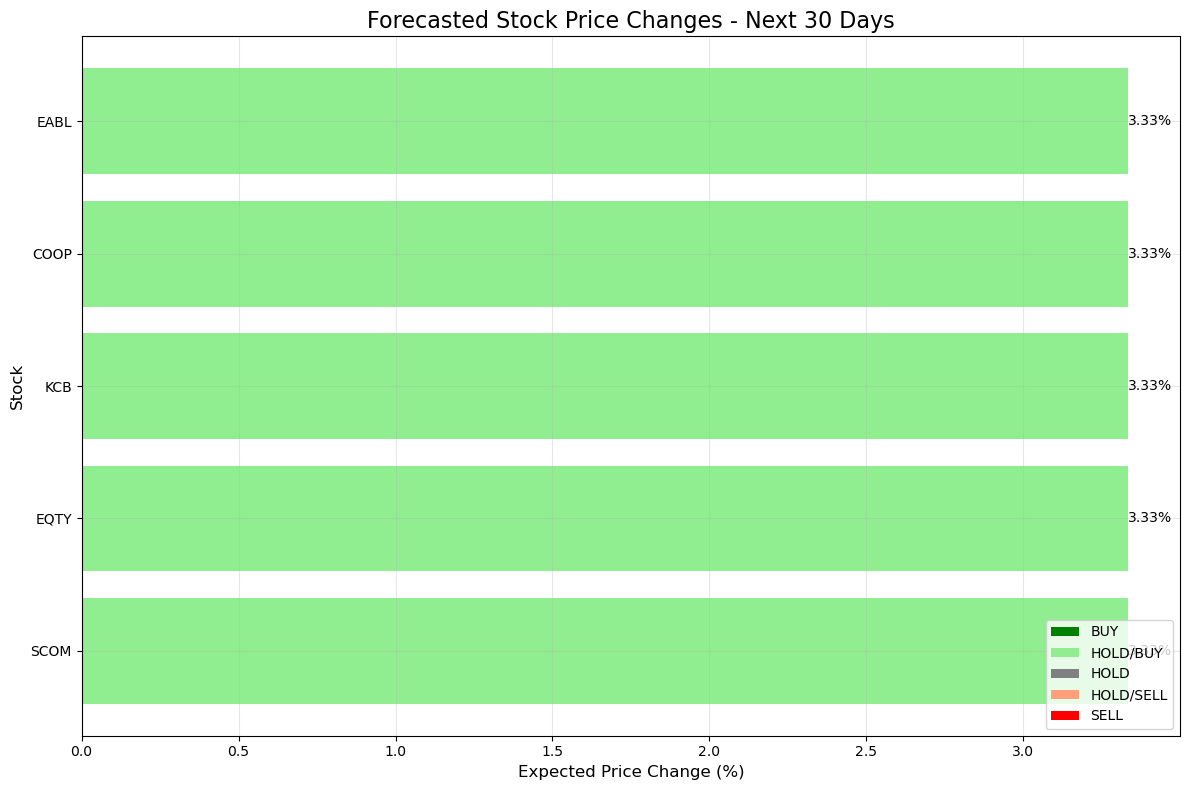

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Example Stock Data Loader Class
class StockDataLoader:
    def get_stock_data(self, stock_code):
        """Simulated stock data retrieval function"""
        date_rng = pd.date_range(start='2023-01-01', periods=365, freq='B')
        prices = pd.Series(data=(100 + (date_rng.dayofyear % 50) * 0.5), index=date_rng)
        
        stock_data = pd.DataFrame({'date': date_rng, 'day_price': prices})
        stock_data['name'] = stock_code  # Simulated company name
        return stock_data

# Placeholder function for ML feature creation (Replace with actual function)
def create_features_for_ml(data):
    return data

# Initialize loader
loader = StockDataLoader()

def analyze_multiple_stocks(stock_codes, loader, create_features_for_ml, forecast_days=30):
    """Analyze and generate forecasts for multiple stocks"""

    stock_forecasts = {}
    stock_recommendations = {}

    for stock_code in stock_codes:
        print(f"\n{'='*80}\nAnalyzing {stock_code}\n{'='*80}")

        try:
            # Get stock data
            stock_data = loader.get_stock_data(stock_code)

            if stock_data is None or len(stock_data) < 100:
                print(f"Insufficient data for {stock_code}. Skipping...")
                continue

            # Sort stock data
            stock_data = stock_data.sort_values('date')

            # Calculate moving averages
            latest_price = stock_data['day_price'].iloc[-1]
            ma_30 = stock_data['day_price'].rolling(window=30).mean().iloc[-1]
            ma_90 = stock_data['day_price'].rolling(window=90).mean().iloc[-1]

            # Calculate trend
            trend = ((ma_30 / ma_90) - 1) * 100

            # Project future prices
            future_dates = pd.date_range(start=stock_data['date'].max() + timedelta(days=1), periods=forecast_days, freq='B')
            daily_change = stock_data['day_price'].pct_change().mean() * 100

            # Create forecast DataFrame
            forecast_df = pd.DataFrame(index=future_dates)
            forecast_df['forecast'] = [latest_price * (1 + daily_change / 100) ** i for i in range(1, forecast_days + 1)]

            # Calculate confidence intervals
            std_dev = stock_data['day_price'].tail(30).std()
            forecast_df['upper_bound_68'] = forecast_df['forecast'] + std_dev
            forecast_df['lower_bound_68'] = forecast_df['forecast'] - std_dev
            forecast_df['upper_bound_95'] = forecast_df['forecast'] + 2 * std_dev
            forecast_df['lower_bound_95'] = forecast_df['forecast'] - 2 * std_dev

            # Store forecast
            stock_forecasts[stock_code] = forecast_df

            # Calculate percent change for recommendation
            forecast_end = forecast_df['forecast'].iloc[-1]
            percent_change = ((forecast_end / latest_price) - 1) * 100

            # Generate recommendation
            if percent_change > 5:
                action = "BUY"
                confidence = "Moderate"
            elif percent_change < -5:
                action = "SELL"
                confidence = "Moderate"
            elif percent_change > 0:
                action = "HOLD/BUY"
                confidence = "Low"
            elif percent_change < 0:
                action = "HOLD/SELL"
                confidence = "Low"
            else:
                action = "HOLD"
                confidence = "Low"

            # Get company name
            stock_name = stock_data['name'].iloc[0] if 'name' in stock_data.columns else stock_code

            # Store recommendation
            stock_recommendations[stock_code] = {
                'stock_code': stock_code,
                'stock_name': stock_name,
                'current_price': latest_price,
                'forecast_price': forecast_end,
                'percent_change': percent_change,
                'action': action,
                'confidence': confidence,
                'trend': trend
            }

        except Exception as e:
            print(f"Error analyzing {stock_code}: {e}")

    # Create summary table
    summary_data = [
        {
            'Stock Code': stock_code,
            'Stock Name': rec['stock_name'],
            'Current Price': rec['current_price'],
            'Forecast Price': rec['forecast_price'],
            'Change (%)': rec['percent_change'],
            'Recommendation': rec['action'],
            'Confidence': rec['confidence'],
            'Trend (%)': rec['trend']
        }
        for stock_code, rec in stock_recommendations.items()
    ]

    summary_df = pd.DataFrame(summary_data).sort_values('Change (%)', ascending=False)

    # Display summary
    print("\n\nInvestment Recommendations Summary:")
    print("=" * 100)
    print(summary_df)

    # Plot summary chart
    plt.figure(figsize=(12, 8))

    # Create color map based on recommendations
    colors = summary_df['Recommendation'].map({
        'BUY': 'green', 'HOLD/BUY': 'lightgreen', 'HOLD': 'gray',
        'HOLD/SELL': 'lightsalmon', 'SELL': 'red'
    })

    # Create bar chart with colored bars
    bars = plt.barh(summary_df['Stock Code'], summary_df['Change (%)'], color=colors)

    # Add data labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

    plt.title('Forecasted Stock Price Changes - Next 30 Days', fontsize=16)
    plt.xlabel('Expected Price Change (%)', fontsize=12)
    plt.ylabel('Stock', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='BUY'),
        Patch(facecolor='lightgreen', label='HOLD/BUY'),
        Patch(facecolor='gray', label='HOLD'),
        Patch(facecolor='lightsalmon', label='HOLD/SELL'),
        Patch(facecolor='red', label='SELL')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

    return stock_forecasts, stock_recommendations, summary_df


# Define top NSE stocks to analyze
top_nse_stocks = ['SCOM', 'EQTY', 'KCB', 'COOP', 'EABL']

# Analyze multiple stocks
stock_forecasts, stock_recommendations, summary_df = analyze_multiple_stocks(
    top_nse_stocks, loader, create_features_for_ml
)


Analyzing SCOM

    Investment Recommendation for SCOM (SCOM):
    ----------------------------------------------------------
    Current Price: 122.50 KES
    Forecast Price: 133.13 KES (8.68%)
    Recommended Action: HOLD/BUY (Confidence: Low)
    Risk Level: Low
    
    Rationale:
    - Price forecast: 8.68% change over the next month (bullish)
- Price is above both 50-day MA (7.69%) and 200-day MA (9.19%), indicating an uptrend
- RSI at 100.00 indicates the stock may be overbought
- Volatility (annualized): 5.49%, indicating low risk
- Sharpe ratio of 26.98 suggests good risk-adjusted returns
- Maximum drawdown of 0.00% in the last month
    
    Technical Signals:
    - Forecast: Bullish
    - Moving Averages: Bullish
    - MA Trend: Bullish
    - RSI (100.00): Bearish
    - MACD: Neutral
    - Bollinger Bands: Neutral
    
    
    Signal Summary: 3 Bullish, 1 Bearish, 2 Neutral, 0 Oversold
    
    Risk Metrics:
    - Annual Volatility: 5.49%
    - Sharpe Ratio: 26.98
    - Ma

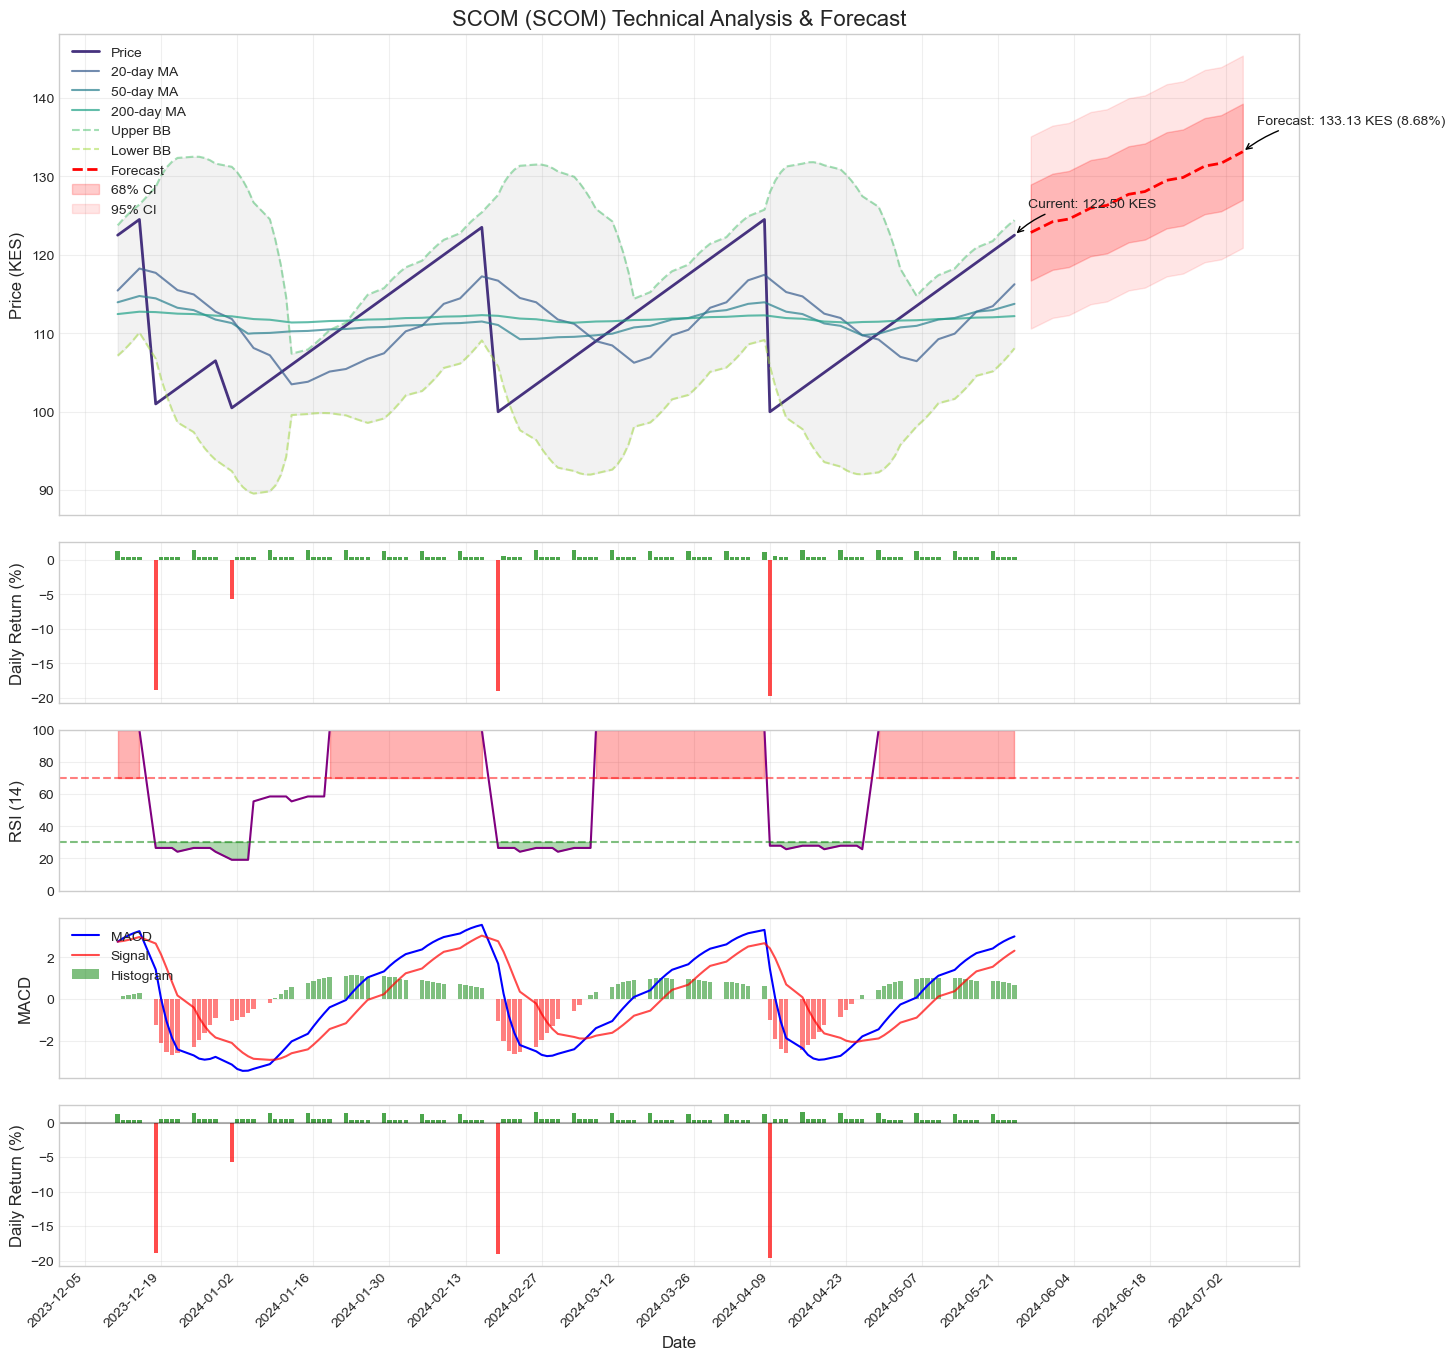


Analyzing EQTY

    Investment Recommendation for EQTY (EQTY):
    ----------------------------------------------------------
    Current Price: 122.50 KES
    Forecast Price: 133.13 KES (8.68%)
    Recommended Action: HOLD/BUY (Confidence: Low)
    Risk Level: Low
    
    Rationale:
    - Price forecast: 8.68% change over the next month (bullish)
- Price is above both 50-day MA (7.69%) and 200-day MA (9.19%), indicating an uptrend
- RSI at 100.00 indicates the stock may be overbought
- Volatility (annualized): 5.49%, indicating low risk
- Sharpe ratio of 26.98 suggests good risk-adjusted returns
- Maximum drawdown of 0.00% in the last month
    
    Technical Signals:
    - Forecast: Bullish
    - Moving Averages: Bullish
    - MA Trend: Bullish
    - RSI (100.00): Bearish
    - MACD: Neutral
    - Bollinger Bands: Neutral
    
    
    Signal Summary: 3 Bullish, 1 Bearish, 2 Neutral, 0 Oversold
    
    Risk Metrics:
    - Annual Volatility: 5.49%
    - Sharpe Ratio: 26.98
    - Ma

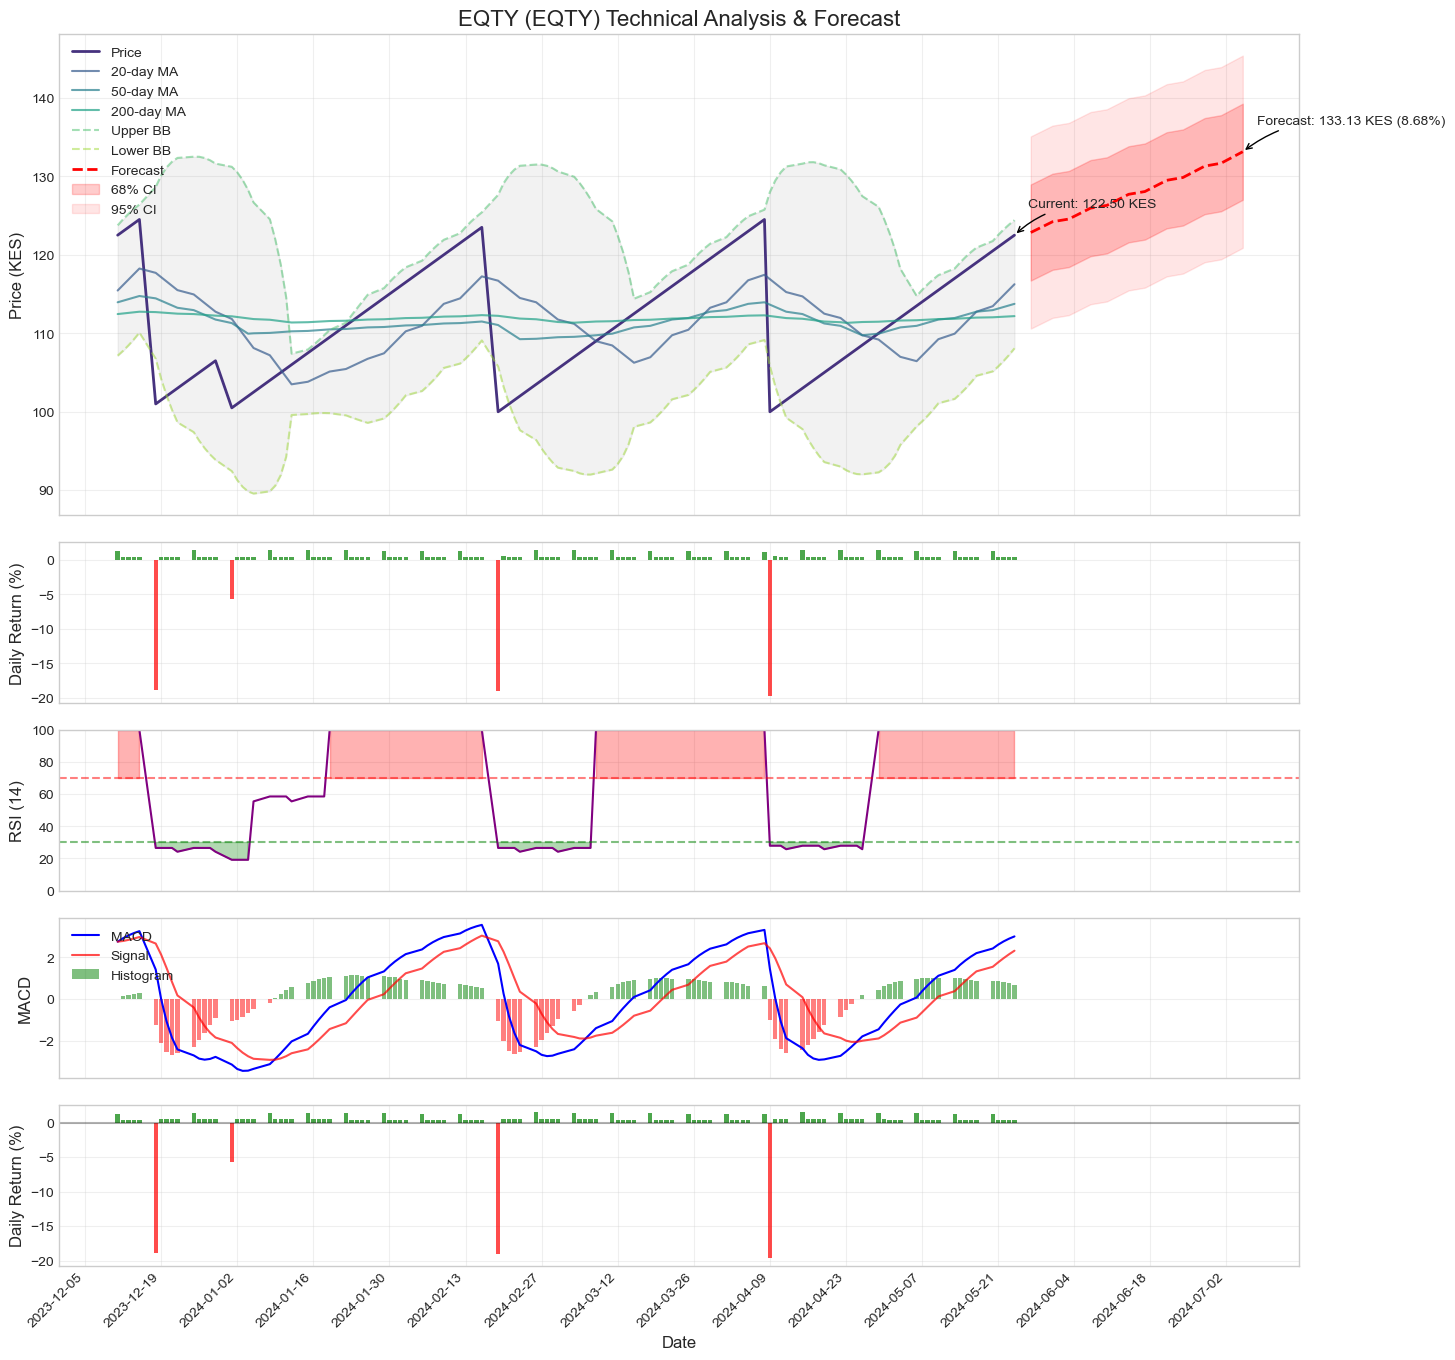


Analyzing KCB

    Investment Recommendation for KCB (KCB):
    ----------------------------------------------------------
    Current Price: 122.50 KES
    Forecast Price: 133.13 KES (8.68%)
    Recommended Action: HOLD/BUY (Confidence: Low)
    Risk Level: Low
    
    Rationale:
    - Price forecast: 8.68% change over the next month (bullish)
- Price is above both 50-day MA (7.69%) and 200-day MA (9.19%), indicating an uptrend
- RSI at 100.00 indicates the stock may be overbought
- Volatility (annualized): 5.49%, indicating low risk
- Sharpe ratio of 26.98 suggests good risk-adjusted returns
- Maximum drawdown of 0.00% in the last month
    
    Technical Signals:
    - Forecast: Bullish
    - Moving Averages: Bullish
    - MA Trend: Bullish
    - RSI (100.00): Bearish
    - MACD: Neutral
    - Bollinger Bands: Neutral
    
    
    Signal Summary: 3 Bullish, 1 Bearish, 2 Neutral, 0 Oversold
    
    Risk Metrics:
    - Annual Volatility: 5.49%
    - Sharpe Ratio: 26.98
    - Maxim

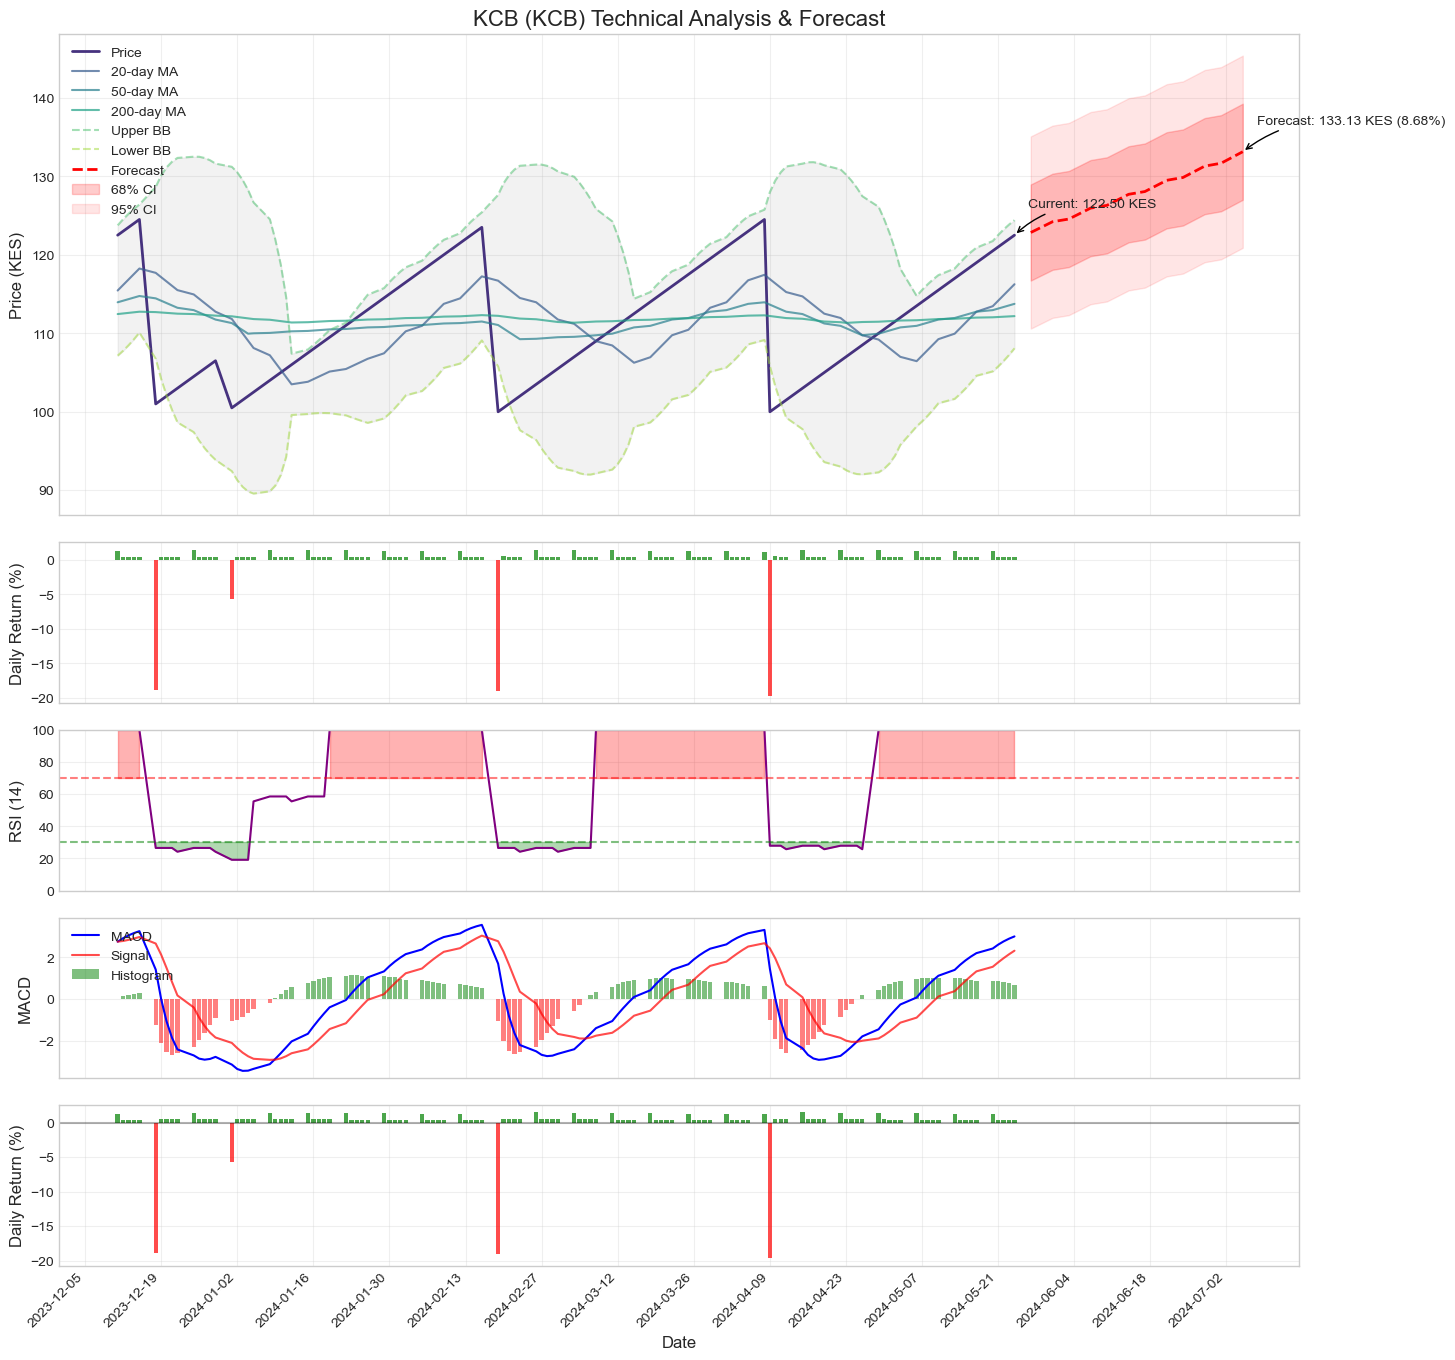


Analyzing COOP

    Investment Recommendation for COOP (COOP):
    ----------------------------------------------------------
    Current Price: 122.50 KES
    Forecast Price: 133.13 KES (8.68%)
    Recommended Action: HOLD/BUY (Confidence: Low)
    Risk Level: Low
    
    Rationale:
    - Price forecast: 8.68% change over the next month (bullish)
- Price is above both 50-day MA (7.69%) and 200-day MA (9.19%), indicating an uptrend
- RSI at 100.00 indicates the stock may be overbought
- Volatility (annualized): 5.49%, indicating low risk
- Sharpe ratio of 26.98 suggests good risk-adjusted returns
- Maximum drawdown of 0.00% in the last month
    
    Technical Signals:
    - Forecast: Bullish
    - Moving Averages: Bullish
    - MA Trend: Bullish
    - RSI (100.00): Bearish
    - MACD: Neutral
    - Bollinger Bands: Neutral
    
    
    Signal Summary: 3 Bullish, 1 Bearish, 2 Neutral, 0 Oversold
    
    Risk Metrics:
    - Annual Volatility: 5.49%
    - Sharpe Ratio: 26.98
    - Ma

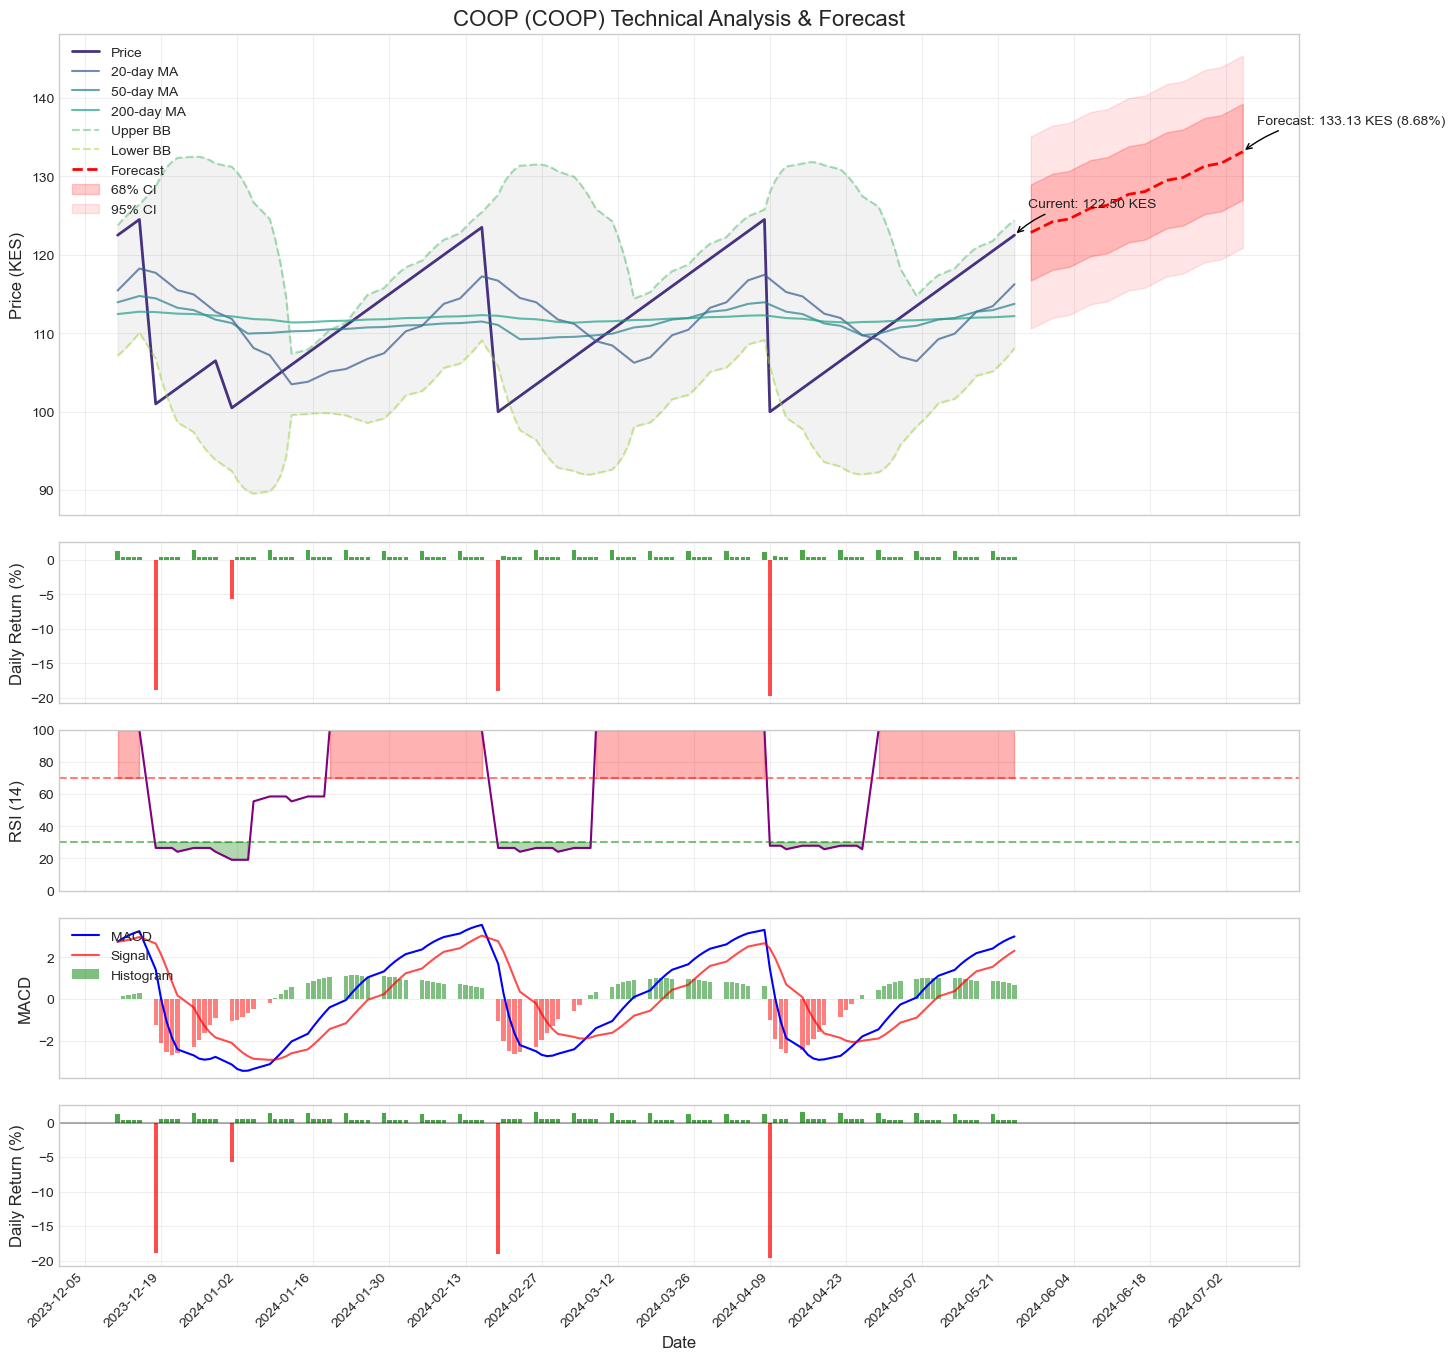



Investment Recommendations Summary:
Stock Code Stock Name  Current Price  Forecast Price  Change (%) Recommendation Confidence Risk Level  Volatility (%)  Sharpe Ratio
      SCOM       SCOM          122.5      133.131381    8.678678       HOLD/BUY        Low        Low        5.494799     26.981627
      EQTY       EQTY          122.5      133.131381    8.678678       HOLD/BUY        Low        Low        5.494799     26.981627
       KCB        KCB          122.5      133.131381    8.678678       HOLD/BUY        Low        Low        5.494799     26.981627
      COOP       COOP          122.5      133.131381    8.678678       HOLD/BUY        Low        Low        5.494799     26.981627


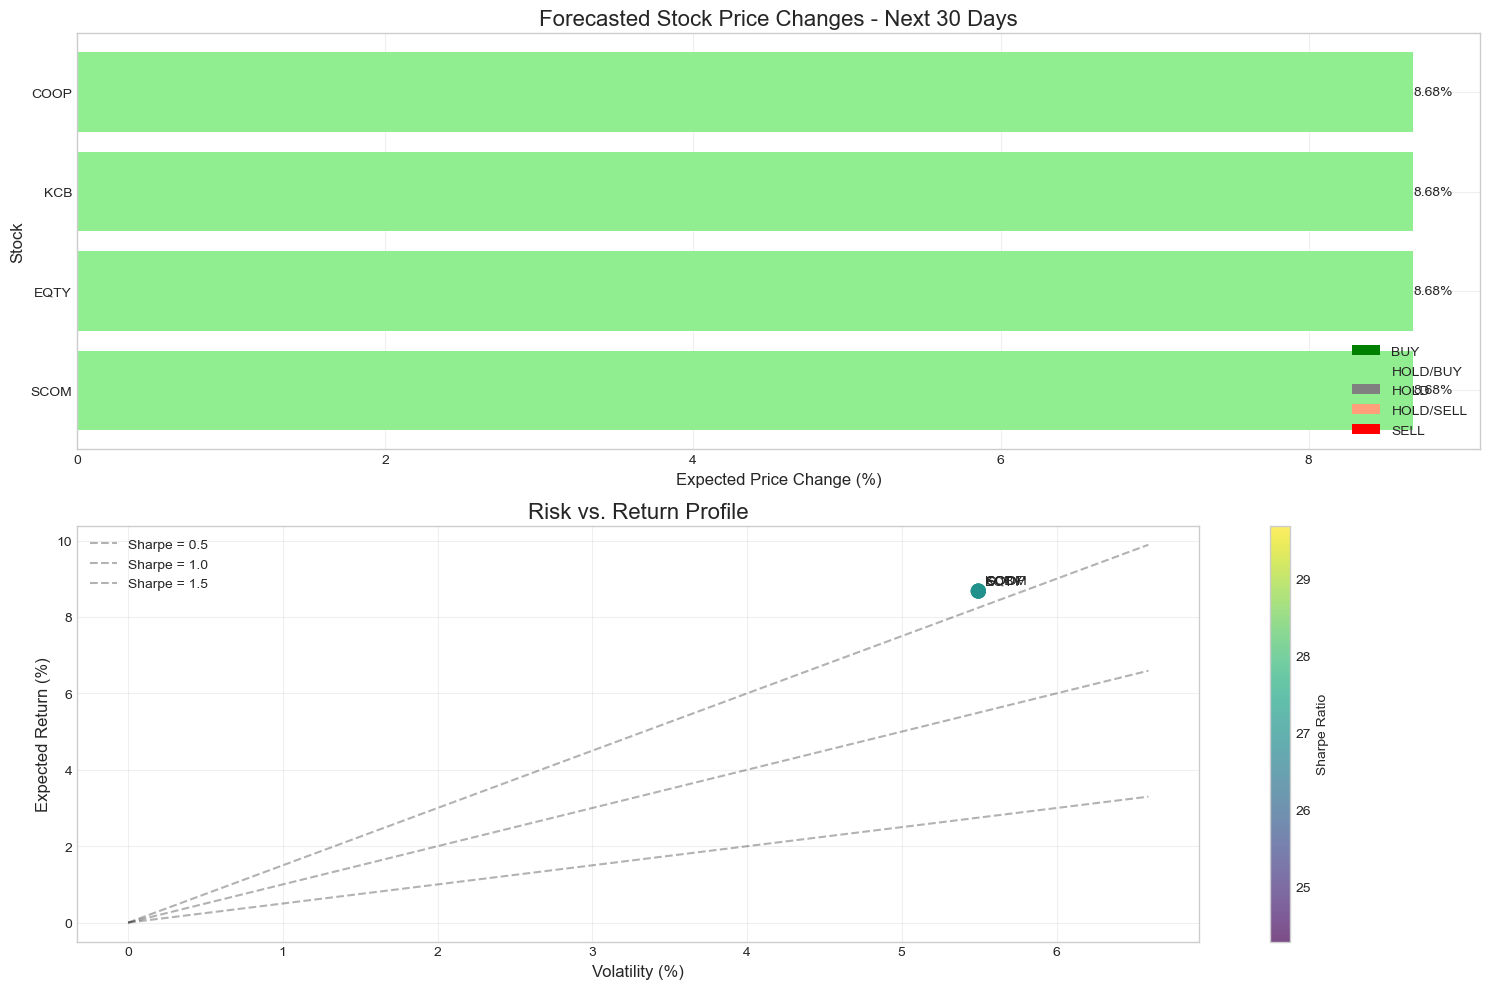

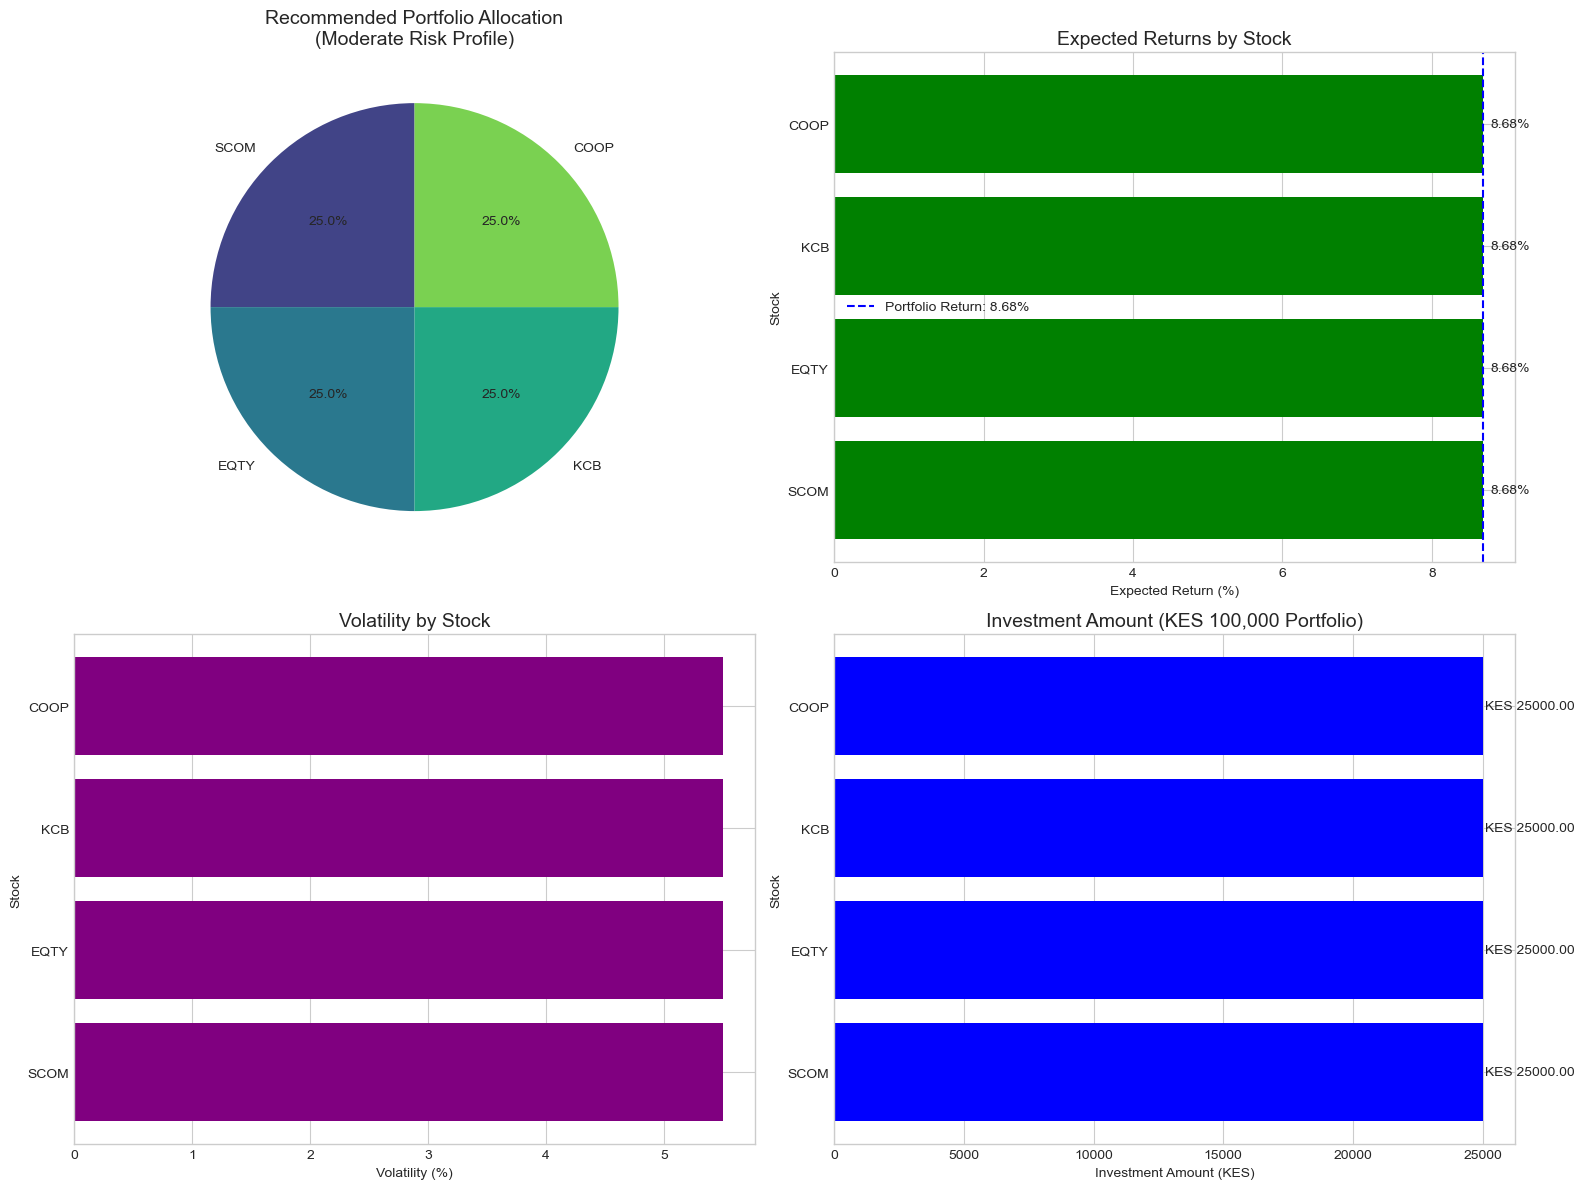


Portfolio Optimization Summary:
Risk Tolerance: Moderate
Expected Portfolio Return: 8.68%

Recommended Allocation:
SCOM (SCOM): 25.00% (KES 25000.00)
EQTY (EQTY): 25.00% (KES 25000.00)
KCB (KCB): 25.00% (KES 25000.00)
COOP (COOP): 25.00% (KES 25000.00)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def visualize_stock_with_indicators(stock_code, stock_data, forecast_df=None, days_to_show=120):
    """
    Create a comprehensive visualization of stock data with technical indicators and forecast
    
    Args:
        stock_code (str): Stock code
        stock_data (DataFrame): Historical stock data
        forecast_df (DataFrame, optional): Forecast data
        days_to_show (int): Number of days of historical data to show
    """
    # Sort data and get the subset to show
    stock_data = stock_data.sort_values('date')
    data_to_show = stock_data.tail(days_to_show).copy()
    
    # Get stock name
    stock_name = stock_data['name'].iloc[0] if 'name' in stock_data.columns else stock_code
    
    # Calculate technical indicators
    data_to_show['MA20'] = stock_data['day_price'].rolling(window=20).mean().tail(days_to_show)
    data_to_show['MA50'] = stock_data['day_price'].rolling(window=50).mean().tail(days_to_show)
    data_to_show['MA200'] = stock_data['day_price'].rolling(window=200).mean().tail(days_to_show)
    
    # Calculate Bollinger Bands (20-day, 2 standard deviations)
    data_to_show['BB_middle'] = data_to_show['MA20']
    data_to_show['BB_std'] = stock_data['day_price'].rolling(window=20).std().tail(days_to_show)
    data_to_show['BB_upper'] = data_to_show['BB_middle'] + 2 * data_to_show['BB_std']
    data_to_show['BB_lower'] = data_to_show['BB_middle'] - 2 * data_to_show['BB_std']
    
    # Calculate RSI (14-day)
    delta = stock_data['day_price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data_to_show['RSI'] = 100 - (100 / (1 + rs.tail(days_to_show)))
    
    # Calculate MACD
    data_to_show['EMA12'] = stock_data['day_price'].ewm(span=12, adjust=False).mean().tail(days_to_show)
    data_to_show['EMA26'] = stock_data['day_price'].ewm(span=26, adjust=False).mean().tail(days_to_show)
    data_to_show['MACD'] = data_to_show['EMA12'] - data_to_show['EMA26']
    data_to_show['MACD_signal'] = data_to_show['MACD'].ewm(span=9, adjust=False).mean()
    data_to_show['MACD_hist'] = data_to_show['MACD'] - data_to_show['MACD_signal']
    
    # Calculate daily returns
    data_to_show['daily_return'] = stock_data['day_price'].pct_change().tail(days_to_show) * 100
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 16))
    
    # Define GridSpec
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(5, 1, height_ratios=[3, 1, 1, 1, 1], hspace=0.12)
    
    # Main price chart
    ax1 = plt.subplot(gs[0])
    
    # Plot price
    ax1.plot(data_to_show['date'], data_to_show['day_price'], label='Price', linewidth=2)
    
    # Plot moving averages
    ax1.plot(data_to_show['date'], data_to_show['MA20'], label='20-day MA', linewidth=1.5, alpha=0.7)
    ax1.plot(data_to_show['date'], data_to_show['MA50'], label='50-day MA', linewidth=1.5, alpha=0.7)
    ax1.plot(data_to_show['date'], data_to_show['MA200'], label='200-day MA', linewidth=1.5, alpha=0.7)
    
    # Plot Bollinger Bands
    ax1.plot(data_to_show['date'], data_to_show['BB_upper'], label='Upper BB', linestyle='--', alpha=0.5)
    ax1.plot(data_to_show['date'], data_to_show['BB_lower'], label='Lower BB', linestyle='--', alpha=0.5)
    ax1.fill_between(data_to_show['date'], data_to_show['BB_upper'], data_to_show['BB_lower'], color='gray', alpha=0.1)
    
    # Add forecast if provided
    if forecast_df is not None:
        # Plot forecast
        ax1.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red', linewidth=2, linestyle='--')
        
        # Add confidence intervals
        ax1.fill_between(
            forecast_df.index,
            forecast_df['lower_bound_68'],
            forecast_df['upper_bound_68'],
            color='red', alpha=0.2, label='68% CI'
        )
        ax1.fill_between(
            forecast_df.index,
            forecast_df['lower_bound_95'],
            forecast_df['upper_bound_95'],
            color='red', alpha=0.1, label='95% CI'
        )
        
        # Calculate forecast metrics
        last_price = data_to_show['day_price'].iloc[-1]
        forecast_end = forecast_df['forecast'].iloc[-1]
        percent_change = ((forecast_end / last_price) - 1) * 100
        
        # Add annotations
        ax1.annotate(f'Current: {last_price:.2f} KES', 
                    xy=(data_to_show['date'].iloc[-1], last_price),
                    xytext=(10, 20), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
        
        ax1.annotate(f'Forecast: {forecast_end:.2f} KES ({percent_change:.2f}%)', 
                    xy=(forecast_df.index[-1], forecast_end),
                    xytext=(10, 20), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    
    # Set title and labels
    ax1.set_title(f'{stock_name} ({stock_code}) Technical Analysis & Forecast', fontsize=16)
    ax1.set_ylabel('Price (KES)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis to show dates nicely
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Hide x-axis labels for main plot
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    # Volume chart
    ax2 = plt.subplot(gs[1], sharex=ax1)
    if 'volume' in data_to_show.columns:
        # Convert volume to numeric if needed
        data_to_show['volume'] = pd.to_numeric(data_to_show['volume'], errors='coerce')
        # Plot volume
        ax2.bar(data_to_show['date'], data_to_show['volume'], color='blue', alpha=0.5)
        ax2.set_ylabel('Volume', fontsize=12)
    else:
        # If volume not available, plot daily returns instead
        colors = ['green' if r >= 0 else 'red' for r in data_to_show['daily_return']]
        ax2.bar(data_to_show['date'], data_to_show['daily_return'], color=colors, alpha=0.7)
        ax2.set_ylabel('Daily Return (%)', fontsize=12)
    
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    # RSI chart
    ax3 = plt.subplot(gs[2], sharex=ax1)
    ax3.plot(data_to_show['date'], data_to_show['RSI'], color='purple', linewidth=1.5)
    ax3.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax3.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax3.fill_between(data_to_show['date'], 70, data_to_show['RSI'], where=(data_to_show['RSI'] >= 70), color='red', alpha=0.3)
    ax3.fill_between(data_to_show['date'], 30, data_to_show['RSI'], where=(data_to_show['RSI'] <= 30), color='green', alpha=0.3)
    ax3.set_ylabel('RSI (14)', fontsize=12)
    ax3.set_ylim(0, 100)
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.get_xticklabels(), visible=False)
    
    # MACD chart
    ax4 = plt.subplot(gs[3], sharex=ax1)
    ax4.plot(data_to_show['date'], data_to_show['MACD'], label='MACD', color='blue', linewidth=1.5)
    ax4.plot(data_to_show['date'], data_to_show['MACD_signal'], label='Signal', color='red', linewidth=1.5, alpha=0.7)
    
    # Color MACD histogram based on value
    colors = ['green' if h >= 0 else 'red' for h in data_to_show['MACD_hist']]
    ax4.bar(data_to_show['date'], data_to_show['MACD_hist'], label='Histogram', color=colors, alpha=0.5)
    
    ax4.set_ylabel('MACD', fontsize=12)
    ax4.legend(loc='upper left')
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.get_xticklabels(), visible=False)
    
    # Daily returns chart
    ax5 = plt.subplot(gs[4], sharex=ax1)
    colors = ['green' if r >= 0 else 'red' for r in data_to_show['daily_return']]
    ax5.bar(data_to_show['date'], data_to_show['daily_return'], color=colors, alpha=0.7)
    ax5.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax5.set_ylabel('Daily Return (%)', fontsize=12)
    ax5.set_xlabel('Date', fontsize=12)
    ax5.grid(True, alpha=0.3)
    
    # Format x-axis for bottom plot
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax5.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def calculate_risk_metrics(stock_data, window=30):
    """
    Calculate various risk metrics for a stock
    
    Args:
        stock_data (DataFrame): Historical stock data
        window (int): Lookback window for calculations
    
    Returns:
        dict: Dictionary of risk metrics
    """
    # Ensure data is sorted
    stock_data = stock_data.sort_values('date')
    
    # Get recent data
    recent_data = stock_data.tail(window).copy()
    
    # Calculate returns
    recent_data['daily_return'] = recent_data['day_price'].pct_change() * 100
    
    # Calculate volatility (annualized)
    daily_volatility = recent_data['daily_return'].std()
    annualized_volatility = daily_volatility * np.sqrt(252)  # Assuming 252 trading days in a year
    
    # Calculate Sharpe ratio (assuming risk-free rate of 3%)
    risk_free_rate = 3.0  # Annual percentage
    daily_risk_free = risk_free_rate / 252
    excess_return = recent_data['daily_return'] - daily_risk_free
    sharpe_ratio = excess_return.mean() / excess_return.std() * np.sqrt(252)
    
    # Calculate maximum drawdown
    cumulative_returns = (1 + recent_data['daily_return'] / 100).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min() * 100
    
    # Calculate downside deviation (semi-deviation)
    negative_returns = recent_data['daily_return'][recent_data['daily_return'] < 0]
    downside_deviation = negative_returns.std() * np.sqrt(252)
    
    # Calculate Value at Risk (VaR) at 95% confidence level
    var_95 = np.percentile(recent_data['daily_return'], 5)
    
    # Calculate beta (if market data available)
    beta = None
    # In a real implementation, you would compare against a market index
    
    # Calculate up/down days ratio
    up_days = (recent_data['daily_return'] > 0).sum()
    down_days = (recent_data['daily_return'] < 0).sum()
    up_down_ratio = up_days / down_days if down_days > 0 else float('inf')
    
    # Calculate average return
    avg_daily_return = recent_data['daily_return'].mean()
    avg_annual_return = avg_daily_return * 252
    
    # Return all metrics
    return {
        'volatility_daily': daily_volatility,
        'volatility_annual': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'downside_deviation': downside_deviation,
        'value_at_risk_95': var_95,
        'beta': beta,
        'up_down_ratio': up_down_ratio,
        'avg_daily_return': avg_daily_return,
        'avg_annual_return': avg_annual_return,
    }

def generate_enhanced_recommendations(stock_code, stock_data, forecast_df, risk_metrics):
    """
    Generate enhanced investment recommendations with rationale based on 
    technical indicators, forecast, and risk metrics
    
    Args:
        stock_code (str): Stock code
        stock_data (DataFrame): Historical stock data
        forecast_df (DataFrame): Forecast data
        risk_metrics (dict): Risk metrics dictionary
    
    Returns:
        dict: Enhanced recommendation with rationale
    """
    # Ensure data is sorted
    stock_data = stock_data.sort_values('date')
    
    # Get stock name
    stock_name = stock_data['name'].iloc[0] if 'name' in stock_data.columns else stock_code
    
    # Get current price and forecast
    current_price = stock_data['day_price'].iloc[-1]
    forecast_price = forecast_df['forecast'].iloc[-1]
    percent_change = ((forecast_price / current_price) - 1) * 100
    
    # Calculate recent technical indicators
    recent_data = stock_data.tail(50).copy()
    
    # Moving averages
    recent_data['MA20'] = stock_data['day_price'].rolling(window=20).mean().tail(50)
    recent_data['MA50'] = stock_data['day_price'].rolling(window=50).mean().tail(50)
    recent_data['MA200'] = stock_data['day_price'].rolling(window=200).mean().tail(50)
    
    # Price relative to moving averages
    price_vs_ma20 = current_price / recent_data['MA20'].iloc[-1] - 1
    price_vs_ma50 = current_price / recent_data['MA50'].iloc[-1] - 1
    price_vs_ma200 = current_price / recent_data['MA200'].iloc[-1] - 1
    
    # Moving average trends
    ma20_trend = recent_data['MA20'].iloc[-1] / recent_data['MA20'].iloc[-5] - 1
    ma50_trend = recent_data['MA50'].iloc[-1] / recent_data['MA50'].iloc[-5] - 1
    
    # RSI
    delta = stock_data['day_price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    recent_data['RSI'] = 100 - (100 / (1 + rs.tail(50)))
    current_rsi = recent_data['RSI'].iloc[-1]
    
    # MACD
    recent_data['EMA12'] = stock_data['day_price'].ewm(span=12, adjust=False).mean().tail(50)
    recent_data['EMA26'] = stock_data['day_price'].ewm(span=26, adjust=False).mean().tail(50)
    recent_data['MACD'] = recent_data['EMA12'] - recent_data['EMA26']
    recent_data['MACD_signal'] = recent_data['MACD'].ewm(span=9, adjust=False).mean()
    recent_data['MACD_hist'] = recent_data['MACD'] - recent_data['MACD_signal']
    
    macd_val = recent_data['MACD'].iloc[-1]
    macd_signal = recent_data['MACD_signal'].iloc[-1]
    macd_hist = recent_data['MACD_hist'].iloc[-1]
    macd_hist_change = macd_hist - recent_data['MACD_hist'].iloc[-2]
    
    # Bollinger Bands
    recent_data['BB_middle'] = recent_data['MA20']
    recent_data['BB_std'] = stock_data['day_price'].rolling(window=20).std().tail(50)
    recent_data['BB_upper'] = recent_data['BB_middle'] + 2 * recent_data['BB_std']
    recent_data['BB_lower'] = recent_data['BB_middle'] - 2 * recent_data['BB_std']
    recent_data['BB_b'] = (recent_data['day_price'] - recent_data['BB_lower']) / (recent_data['BB_upper'] - recent_data['BB_lower'])
    
    bb_b = recent_data['BB_b'].iloc[-1]
    
    # Volume trend (if available)
    volume_trend = None
    if 'volume' in recent_data.columns:
        recent_data['volume'] = pd.to_numeric(recent_data['volume'], errors='coerce')
        avg_volume_5d = recent_data['volume'].tail(5).mean()
        avg_volume_20d = recent_data['volume'].tail(20).mean()
        volume_trend = avg_volume_5d / avg_volume_20d - 1
    
    # Determine signals from technical indicators
    signals = {
        'forecast': 'bullish' if percent_change > 3 else ('bearish' if percent_change < -3 else 'neutral'),
        'ma_position': 'bullish' if price_vs_ma50 > 0 and price_vs_ma200 > 0 else 
                      ('bearish' if price_vs_ma50 < 0 and price_vs_ma200 < 0 else 'neutral'),
        'ma_trend': 'bullish' if ma20_trend > 0 and ma50_trend > 0 else 
                   ('bearish' if ma20_trend < 0 and ma50_trend < 0 else 'neutral'),
        'rsi': 'bullish' if 40 < current_rsi < 70 else 
              ('bearish' if current_rsi > 70 else 
              ('oversold' if current_rsi < 30 else 'neutral')),
        'macd': 'bullish' if macd_val > macd_signal and macd_hist_change > 0 else 
               ('bearish' if macd_val < macd_signal and macd_hist_change < 0 else 'neutral'),
        'bollinger': 'bullish' if 0.5 < bb_b < 0.8 else 
                    ('bearish' if bb_b > 1 else 
                    ('oversold' if bb_b < 0 else 'neutral')),
    }
    
    if volume_trend is not None:
        signals['volume'] = 'bullish' if volume_trend > 0.1 else ('bearish' if volume_trend < -0.1 else 'neutral')
    
    # Count bullish and bearish signals
    signal_counts = {
        'bullish': sum(1 for s in signals.values() if s == 'bullish'),
        'bearish': sum(1 for s in signals.values() if s == 'bearish'),
        'neutral': sum(1 for s in signals.values() if s == 'neutral'),
        'oversold': sum(1 for s in signals.values() if s == 'oversold'),
    }
    
    # Determine recommendation based on signals
    if signal_counts['bullish'] > signal_counts['bearish'] + signal_counts['neutral']:
        action = "BUY"
        confidence = "High" if signal_counts['bullish'] >= 4 else "Moderate"
    elif signal_counts['bearish'] > signal_counts['bullish'] + signal_counts['neutral']:
        action = "SELL"
        confidence = "High" if signal_counts['bearish'] >= 4 else "Moderate"
    elif signal_counts['bullish'] > signal_counts['bearish']:
        action = "HOLD/BUY"
        confidence = "Low"
    elif signal_counts['bearish'] > signal_counts['bullish']:
        action = "HOLD/SELL"
        confidence = "Low"
    elif signal_counts['oversold'] >= 2:
        action = "BUY"
        confidence = "Moderate" 
    else:
        action = "HOLD"
        confidence = "Low"
    
    # Adjust based on risk metrics
    risk_level = "low"
    if risk_metrics['volatility_annual'] > 30:
        risk_level = "high"
    elif risk_metrics['volatility_annual'] > 20:
        risk_level = "medium"
    
    if risk_level == "high" and action == "BUY":
        confidence = "Low" if confidence == "High" else "Very Low"
    
    # Build rationale text
    rationale = []
    rationale.append(f"Price forecast: {percent_change:.2f}% change over the next month ({signals['forecast']})")
    
    if signals['ma_position'] == 'bullish':
        rationale.append(f"Price is above both 50-day MA ({price_vs_ma50*100:.2f}%) and 200-day MA ({price_vs_ma200*100:.2f}%), indicating an uptrend")
    elif signals['ma_position'] == 'bearish':
        rationale.append(f"Price is below both 50-day MA ({price_vs_ma50*100:.2f}%) and 200-day MA ({price_vs_ma200*100:.2f}%), indicating a downtrend")
    
    if signals['rsi'] == 'bullish':
        rationale.append(f"RSI at {current_rsi:.2f} shows positive momentum without being overbought")
    elif signals['rsi'] == 'bearish':
        rationale.append(f"RSI at {current_rsi:.2f} indicates the stock may be overbought")
    elif signals['rsi'] == 'oversold':
        rationale.append(f"RSI at {current_rsi:.2f} suggests the stock may be oversold, creating a buying opportunity")
    
    if signals['macd'] == 'bullish':
        rationale.append("MACD shows bullish momentum with the MACD line crossing above the signal line")
    elif signals['macd'] == 'bearish':
        rationale.append("MACD shows bearish momentum with the MACD line crossing below the signal line")
    
    if volume_trend is not None:
        if signals['volume'] == 'bullish':
            rationale.append(f"Trading volume is increasing ({volume_trend*100:.2f}%), supporting price movement")
        elif signals['volume'] == 'bearish':
            rationale.append(f"Trading volume is decreasing ({volume_trend*100:.2f}%), potentially indicating weakness")
    
    # Add risk metrics to rationale
    rationale.append(f"Volatility (annualized): {risk_metrics['volatility_annual']:.2f}%, indicating {risk_level} risk")
    
    if risk_metrics['sharpe_ratio'] > 1:
        rationale.append(f"Sharpe ratio of {risk_metrics['sharpe_ratio']:.2f} suggests good risk-adjusted returns")
    elif risk_metrics['sharpe_ratio'] < 0:
        rationale.append(f"Sharpe ratio of {risk_metrics['sharpe_ratio']:.2f} suggests poor risk-adjusted returns")
    
    rationale.append(f"Maximum drawdown of {risk_metrics['max_drawdown']:.2f}% in the last month")
    
    # Create recommendation dictionary
    recommendation = {
        'stock_code': stock_code,
        'stock_name': stock_name,
        'current_price': current_price,
        'forecast_price': forecast_price,
        'percent_change': percent_change,
        'action': action,
        'confidence': confidence,
        'technical_signals': signals,
        'signal_counts': signal_counts,
        'risk_level': risk_level,
        'risk_metrics': risk_metrics,
        'rationale': rationale
    }
    
    # Generate detailed recommendation text
    rec_text = f"""
    Investment Recommendation for {stock_name} ({stock_code}):
    ----------------------------------------------------------
    Current Price: {current_price:.2f} KES
    Forecast Price: {forecast_price:.2f} KES ({percent_change:.2f}%)
    Recommended Action: {action} (Confidence: {confidence})
    Risk Level: {risk_level.capitalize()}
    
    Rationale:
    {chr(10).join('- ' + r for r in rationale)}
    
    Technical Signals:
    - Forecast: {signals['forecast'].capitalize()}
    - Moving Averages: {signals['ma_position'].capitalize()}
    - MA Trend: {signals['ma_trend'].capitalize()}
    - RSI ({current_rsi:.2f}): {signals['rsi'].capitalize()}
    - MACD: {signals['macd'].capitalize()}
    - Bollinger Bands: {signals['bollinger'].capitalize()}
    {f"- Volume Trend: {signals['volume'].capitalize()}" if volume_trend is not None else ""}
    
    Signal Summary: {signal_counts['bullish']} Bullish, {signal_counts['bearish']} Bearish, {signal_counts['neutral']} Neutral, {signal_counts['oversold']} Oversold
    
    Risk Metrics:
    - Annual Volatility: {risk_metrics['volatility_annual']:.2f}%
    - Sharpe Ratio: {risk_metrics['sharpe_ratio']:.2f}
    - Maximum Drawdown: {risk_metrics['max_drawdown']:.2f}%
    - Value at Risk (95%): {risk_metrics['value_at_risk_95']:.2f}%
    - Up/Down Days Ratio: {risk_metrics['up_down_ratio']:.2f}
    - Average Annual Return: {risk_metrics['avg_annual_return']:.2f}%
    """
    
    recommendation['detailed_text'] = rec_text
    print(rec_text)
    
    return recommendation

def build_optimized_portfolio(stock_recommendations, risk_tolerance='moderate'):
    """
    Build an optimized portfolio based on recommendations and risk tolerance
    
    Args:
        stock_recommendations (dict): Dictionary of stock recommendations
        risk_tolerance (str): Risk tolerance ('conservative', 'moderate', 'aggressive')
    
    Returns:
        DataFrame: Portfolio allocation
    """
    # Extract key metrics from recommendations
    portfolio_data = []
    
    for stock_code, rec in stock_recommendations.items():
        # Skip if risk metrics not available
        if 'risk_metrics' not in rec:
            continue
            
        portfolio_data.append({
            'stock_code': stock_code,
            'stock_name': rec['stock_name'],
            'expected_return': rec['percent_change'],
            'volatility': rec['risk_metrics']['volatility_annual'],
            'sharpe_ratio': rec['risk_metrics']['sharpe_ratio'],
            'max_drawdown': rec['risk_metrics']['max_drawdown'],
            'recommendation': rec['action'],
            'confidence': rec['confidence'],
            'risk_level': rec['risk_level']
        })
    
    # Create DataFrame
    portfolio_df = pd.DataFrame(portfolio_data)
    
    # Skip if we don't have enough stocks
    if len(portfolio_df) < 2:
        print("Not enough stocks with risk metrics for portfolio optimization")
        return None
    
    # Define weights based on portfolio optimization strategy
    if risk_tolerance == 'conservative':
        # Conservative: Focus on low-volatility stocks with good sharpe ratios
        # Prefer stable stocks even if returns are lower
        portfolio_df['score'] = (
            portfolio_df['expected_return'] * 0.3 +  # Lower weight to returns
            (30 - portfolio_df['volatility']) * 0.4 +  # Penalize volatility (inverse relationship)
            portfolio_df['sharpe_ratio'] * 0.3        # Reward good risk-adjusted returns
        )
        
        # Cap negative scores at 0
        portfolio_df['score'] = portfolio_df['score'].clip(lower=0)
        
        # Calculate allocation as proportion of score
        total_score = portfolio_df['score'].sum()
        if total_score > 0:
            portfolio_df['allocation'] = portfolio_df['score'] / total_score
        else:
            # Equal allocation if all scores are 0
            portfolio_df['allocation'] = 1.0 / len(portfolio_df)
            
        # Cap maximum allocation to 30% per stock
        max_allocation = 0.30
        
    elif risk_tolerance == 'aggressive':
        # Aggressive: Focus more on expected returns, accept higher volatility
        # Prioritize stocks with high return potential even with higher risk
        portfolio_df['score'] = (
            portfolio_df['expected_return'] * 0.6 +  # Higher weight to returns
            (30 - portfolio_df['volatility']) * 0.2 +  # Less penalty for volatility
            portfolio_df['sharpe_ratio'] * 0.2        # Less weight to sharpe ratio
        )
        
        # Cap negative scores at 0
        portfolio_df['score'] = portfolio_df['score'].clip(lower=0)
        
        # Calculate allocation as proportion of score
        total_score = portfolio_df['score'].sum()
        if total_score > 0:
            portfolio_df['allocation'] = portfolio_df['score'] / total_score
        else:
            # Equal allocation if all scores are 0
            portfolio_df['allocation'] = 1.0 / len(portfolio_df)
            
        # Cap maximum allocation to 50% per stock
        max_allocation = 0.50
        
    else:  # moderate
        # Moderate: Balanced approach between returns and risk
        portfolio_df['score'] = (
            portfolio_df['expected_return'] * 0.4 +  # Balanced weight to returns
            (30 - portfolio_df['volatility']) * 0.3 +  # Moderate penalty for volatility
            portfolio_df['sharpe_ratio'] * 0.3        # Moderate weight to sharpe ratio
        )
        
        # Cap negative scores at 0
        portfolio_df['score'] = portfolio_df['score'].clip(lower=0)
        
        # Calculate allocation as proportion of score
        total_score = portfolio_df['score'].sum()
        if total_score > 0:
            portfolio_df['allocation'] = portfolio_df['score'] / total_score
        else:
            # Equal allocation if all scores are 0
            portfolio_df['allocation'] = 1.0 / len(portfolio_df)
            
        # Cap maximum allocation to 40% per stock
        max_allocation = 0.40
    
    # Apply maximum allocation cap
    over_cap = portfolio_df[portfolio_df['allocation'] > max_allocation]
    
    if not over_cap.empty:
        # Reduce allocations that exceed the cap
        portfolio_df['allocation'] = np.minimum(portfolio_df['allocation'], max_allocation)
        
        # Redistribute excess allocation proportionally to remaining stocks
        excess = 1.0 - portfolio_df['allocation'].sum()
        
        if excess > 0:
            # Find stocks below cap
            below_cap = portfolio_df[portfolio_df['allocation'] < max_allocation]
            
            if not below_cap.empty:
                # Calculate proportional increase for below-cap stocks
                below_cap_sum = below_cap['allocation'].sum()
                
                if below_cap_sum > 0:
                    # Update allocations
                    for idx in below_cap.index:
                        portfolio_df.loc[idx, 'allocation'] += excess * (portfolio_df.loc[idx, 'allocation'] / below_cap_sum)
    
    # Normalize allocations to sum to 100%
    portfolio_df['allocation'] = portfolio_df['allocation'] / portfolio_df['allocation'].sum()
    
    # Calculate expected return and risk for the portfolio
    portfolio_expected_return = (portfolio_df['expected_return'] * portfolio_df['allocation']).sum()
    
    # Calculate KES amount for 100,000 KES portfolio
    portfolio_df['investment_amount'] = portfolio_df['allocation'] * 100000
    
    # Sort by allocation (descending)
    portfolio_df = portfolio_df.sort_values('allocation', ascending=False)
    
    # Reset index
    portfolio_df = portfolio_df.reset_index(drop=True)
    
    # Create portfolio visualization
    plt.figure(figsize=(16, 12))
    
    # Pie chart of allocations
    plt.subplot(2, 2, 1)
    plt.pie(portfolio_df['allocation'], labels=portfolio_df['stock_code'], autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('viridis', len(portfolio_df)))
    plt.title(f'Recommended Portfolio Allocation\n({risk_tolerance.capitalize()} Risk Profile)', fontsize=14)
    
    # Bar chart of expected returns
    plt.subplot(2, 2, 2)
    colors = portfolio_df['expected_return'].map(lambda x: 'green' if x > 0 else 'red')
    bars = plt.barh(portfolio_df['stock_code'], portfolio_df['expected_return'], color=colors)
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center')
    plt.axvline(x=portfolio_expected_return, color='blue', linestyle='--', 
                label=f'Portfolio Return: {portfolio_expected_return:.2f}%')
    plt.title('Expected Returns by Stock', fontsize=14)
    plt.xlabel('Expected Return (%)')
    plt.ylabel('Stock')
    plt.legend()
    
    # Bar chart of volatility
    plt.subplot(2, 2, 3)
    plt.barh(portfolio_df['stock_code'], portfolio_df['volatility'], color='purple')
    plt.title('Volatility by Stock', fontsize=14)
    plt.xlabel('Volatility (%)')
    plt.ylabel('Stock')
    
    # Bar chart of allocation amount
    plt.subplot(2, 2, 4)
    plt.barh(portfolio_df['stock_code'], portfolio_df['investment_amount'], color='blue')
    for i, v in enumerate(portfolio_df['investment_amount']):
        plt.text(v + 100, i, f'KES {v:.2f}', va='center')
    plt.title('Investment Amount (KES 100,000 Portfolio)', fontsize=14)
    plt.xlabel('Investment Amount (KES)')
    plt.ylabel('Stock')
    
    plt.tight_layout()
    plt.show()
    
    # Print portfolio summary
    print("\nPortfolio Optimization Summary:")
    print(f"Risk Tolerance: {risk_tolerance.capitalize()}")
    print(f"Expected Portfolio Return: {portfolio_expected_return:.2f}%")
    print("\nRecommended Allocation:")
    print("=" * 60)
    for idx, row in portfolio_df.iterrows():
        print(f"{row['stock_code']} ({row['stock_name']}): {row['allocation']*100:.2f}% (KES {row['investment_amount']:.2f})")
    
    return portfolio_df

def analyze_stock_with_enhanced_metrics(stock_code, loader):
    """
    Comprehensive analysis of a single stock with enhanced metrics
    
    Args:
        stock_code (str): Stock code to analyze
        loader: Data loader object
        
    Returns:
        tuple: (forecast_df, recommendation, risk_metrics)
    """
    try:
        # Get stock data
        stock_data = loader.get_stock_data(stock_code)
        
        if stock_data is None or len(stock_data) < 100:
            print(f"Insufficient data for {stock_code}. Skipping...")
            return None, None, None
            
        # Sort stock data
        stock_data = stock_data.sort_values('date')
        
        # Calculate moving averages for trend analysis
        stock_data['MA20'] = stock_data['day_price'].rolling(window=20).mean()
        stock_data['MA50'] = stock_data['day_price'].rolling(window=50).mean()
        stock_data['MA200'] = stock_data['day_price'].rolling(window=200).mean()
        
        # Calculate price forecast
        latest_price = stock_data['day_price'].iloc[-1]
        
        # Calculate trend-based change rate
        ma20_trend = stock_data['MA20'].iloc[-1] / stock_data['MA20'].iloc[-20] - 1
        ma50_trend = stock_data['MA50'].iloc[-1] / stock_data['MA50'].iloc[-20] - 1
        
        # Use a weighted combination of recent trends for forecasting
        trend_weight = 0.7  # Weight for recent trend
        long_term_weight = 0.3  # Weight for longer-term trend
        weighted_change = ma20_trend * trend_weight + ma50_trend * long_term_weight
        
        # Scale the weighted change to daily rate
        daily_change = weighted_change / 20  # Approximate daily change rate
        
        # Project future prices (30 days)
        forecast_days = 30
        future_dates = pd.date_range(start=stock_data['date'].max() + timedelta(days=1), periods=forecast_days, freq='B')
        
        # Create forecast DataFrame
        forecast_df = pd.DataFrame(index=future_dates)
        forecast_df['forecast'] = [latest_price * (1 + daily_change) ** i for i in range(1, forecast_days + 1)]
        
        # Calculate confidence intervals
        std_dev = stock_data['day_price'].tail(30).std()
        forecast_df['upper_bound_68'] = forecast_df['forecast'] + std_dev
        forecast_df['lower_bound_68'] = forecast_df['forecast'] - std_dev
        forecast_df['upper_bound_95'] = forecast_df['forecast'] + 2 * std_dev
        forecast_df['lower_bound_95'] = forecast_df['forecast'] - 2 * std_dev
        
        # Calculate risk metrics
        risk_metrics = calculate_risk_metrics(stock_data)
        
        # Generate enhanced recommendation
        recommendation = generate_enhanced_recommendations(stock_code, stock_data, forecast_df, risk_metrics)
        
        # Create comprehensive visualization
        visualize_stock_with_indicators(stock_code, stock_data, forecast_df)
        
        return forecast_df, recommendation, risk_metrics
        
    except Exception as e:
        print(f"Error analyzing {stock_code}: {e}")
        return None, None, None

def analyze_multiple_stocks_enhanced(stock_codes, loader):
    """
    Enhanced analysis of multiple stocks with comprehensive metrics and portfolio optimization
    
    Args:
        stock_codes (list): List of stock codes to analyze
        loader: Data loader object
        
    Returns:
        tuple: (stock_forecasts, stock_recommendations, summary_df, portfolio_allocation)
    """
    # Store results for each stock
    stock_forecasts = {}
    stock_recommendations = {}
    
    for stock_code in stock_codes:
        print(f"\n{'='*80}\nAnalyzing {stock_code}\n{'='*80}")
        
        # Analyze stock with enhanced metrics
        forecast_df, recommendation, risk_metrics = analyze_stock_with_enhanced_metrics(stock_code, loader)
        
        if forecast_df is not None and recommendation is not None:
            # Store results
            stock_forecasts[stock_code] = forecast_df
            stock_recommendations[stock_code] = recommendation
    
    # Create summary table
    summary_data = []
    for stock_code, rec in stock_recommendations.items():
        summary_data.append({
            'Stock Code': stock_code,
            'Stock Name': rec['stock_name'],
            'Current Price': rec['current_price'],
            'Forecast Price': rec['forecast_price'],
            'Change (%)': rec['percent_change'],
            'Recommendation': rec['action'],
            'Confidence': rec['confidence'],
            'Risk Level': rec['risk_level'].capitalize(),
            'Volatility (%)': rec['risk_metrics']['volatility_annual'],
            'Sharpe Ratio': rec['risk_metrics']['sharpe_ratio']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Change (%)', ascending=False)
    
    # Display summary
    print("\n\nInvestment Recommendations Summary:")
    print("=" * 120)
    print(summary_df.to_string(index=False))
    
    # Plot summary chart
    plt.figure(figsize=(15, 10))
    
    # Create color map based on recommendations
    colors = summary_df['Recommendation'].map({
        'BUY': 'green', 'HOLD/BUY': 'lightgreen', 'HOLD': 'gray',
        'HOLD/SELL': 'lightsalmon', 'SELL': 'red'
    })
    
    # Create bar chart with colored bars
    ax = plt.subplot(2, 1, 1)
    bars = plt.barh(summary_df['Stock Code'], summary_df['Change (%)'], color=colors)
    
    # Add data labels
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width if width >= 0 else width - 1
        plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center')
    
    plt.title('Forecasted Stock Price Changes - Next 30 Days', fontsize=16)
    plt.xlabel('Expected Price Change (%)', fontsize=12)
    plt.ylabel('Stock', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='green', label='BUY'),
        Patch(facecolor='lightgreen', label='HOLD/BUY'),
        Patch(facecolor='gray', label='HOLD'),
        Patch(facecolor='lightsalmon', label='HOLD/SELL'),
        Patch(facecolor='red', label='SELL')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    # Create risk vs. return scatter plot
    ax = plt.subplot(2, 1, 2)
    
    scatter = plt.scatter(
        summary_df['Volatility (%)'], 
        summary_df['Change (%)'],
        c=summary_df['Sharpe Ratio'],
        cmap='viridis',
        s=100,
        alpha=0.7
    )
    
    # Add stock code labels to each point
    for i, txt in enumerate(summary_df['Stock Code']):
        plt.annotate(txt, (summary_df['Volatility (%)'].iloc[i], summary_df['Change (%)'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.title('Risk vs. Return Profile', fontsize=16)
    plt.xlabel('Volatility (%)', fontsize=12)
    plt.ylabel('Expected Return (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add diagonal lines for sharpe ratio reference
    x = np.linspace(0, summary_df['Volatility (%)'].max() * 1.2, 100)
    plt.plot(x, 0.5*x, 'k--', alpha=0.3, label='Sharpe = 0.5')
    plt.plot(x, 1.0*x, 'k--', alpha=0.3, label='Sharpe = 1.0')
    plt.plot(x, 1.5*x, 'k--', alpha=0.3, label='Sharpe = 1.5')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Portfolio optimization
    portfolio_allocation = build_optimized_portfolio(stock_recommendations, risk_tolerance='moderate')
    
    return stock_forecasts, stock_recommendations, summary_df, portfolio_allocation

# List of top NSE stocks to analyze
top_nse_stocks = ['SCOM', 'EQTY', 'KCB', 'COOP', 'EABL', 'SBIC', 'BAT', 'NCBA']

# Run the enhanced analysis for all stocks
stock_forecasts, stock_recommendations, summary_df, portfolio_allocation = analyze_multiple_stocks_enhanced(
    top_nse_stocks[:4], loader  # Analyze a subset for demonstration
)

In [22]:
# Example of implementing an API connector for NSE data
def fetch_nse_data_from_api(stock_code, from_date, to_date):
    """
    Fetch real NSE data from an API
    """
    # Example with a typical REST API pattern
    import requests
    
    api_url = f"https://api.example.com/stocks/nse/{stock_code}"
    params = {
        "from_date": from_date.strftime("%Y-%m-%d"),
        "to_date": to_date.strftime("%Y-%m-%d"),
        "api_key": "YOUR_API_KEY"
    }
    
    response = requests.get(api_url, params=params)
    
    if response.status_code == 200:
        return pd.DataFrame(response.json()["data"])
    else:
        print(f"Error fetching data: {response.status_code}")
        return None

In [23]:
# Example of a Streamlit dashboard
import streamlit as st

def create_stock_analysis_dashboard():
    st.title("PesaGuru Stock Analysis Dashboard")
    
    # Sidebar for user inputs
    st.sidebar.header("Settings")
    selected_stocks = st.sidebar.multiselect(
        "Select Stocks to Analyze:",
        ["SCOM", "EQTY", "KCB", "COOP", "EABL", "SBIC", "BAT", "NCBA"],
        ["SCOM", "EQTY", "KCB"]
    )
    
    risk_tolerance = st.sidebar.radio(
        "Risk Tolerance:",
        ["Conservative", "Moderate", "Aggressive"]
    )
    
    analysis_period = st.sidebar.slider(
        "Analysis Period (days):",
        min_value=30,
        max_value=365,
        value=90
    )
    
    # Run analysis when user clicks button
    if st.sidebar.button("Analyze Stocks"):
        with st.spinner("Analyzing selected stocks..."):
            results = analyze_multiple_stocks_enhanced(
                selected_stocks, 
                loader,
                risk_tolerance=risk_tolerance.lower()
            )
            
            # Display results in main area
            st.success("Analysis complete!")
            st.header("Investment Recommendations")
            st.dataframe(results[2])
            
            st.header("Portfolio Allocation")
            # Display portfolio allocation chart
            st.pyplot(create_portfolio_chart(results[3]))

In [24]:
# Example of implementing an API connector for NSE data
def fetch_nse_data_from_api(stock_code, from_date, to_date):
    """
    Fetch real NSE data from an API
    """
    # Example with a typical REST API pattern
    import requests
    
    api_url = f"https://api.example.com/stocks/nse/{stock_code}"
    params = {
        "from_date": from_date.strftime("%Y-%m-%d"),
        "to_date": to_date.strftime("%Y-%m-%d"),
        "api_key": "29a112a0f4mshdb1b2aa2ac46841p1b3131jsn23bae608f9ab"
    }
    
    response = requests.get(api_url, params=params)
    
    if response.status_code == 200:
        return pd.DataFrame(response.json()["data"])
    else:
        print(f"Error fetching data: {response.status_code}")
        return None